# Signate開始時のお約束

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [66]:
!pip install signate

In [67]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [68]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [69]:
!pip install kanjize

In [70]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [71]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [72]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]
    # 数値変換し5足す
    tmp = int(tmp)
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

<ipython-input-72-766871c38253>:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

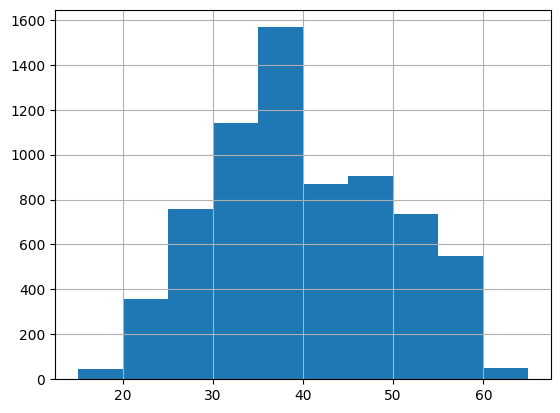

In [73]:
all_df["Age"].hist()

In [74]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損を埋める
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

In [75]:
# 分類の確認
all_df["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,4462
Company Invited,2516


In [76]:
#########################
# "CityTier"の処理 #
#########################
# 分類の確認
all_df["CityTier"].value_counts()
# all_df["CityTier"].isnull().sum()

,count
CityTier,
2,3160
1,2991
3,827


In [77]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

<Axes: >

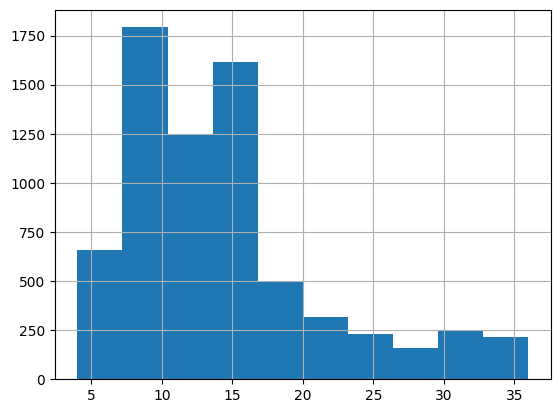

In [78]:
# 分布の確認
all_df["DurationOfPitch"].hist()

In [79]:
####################
# "Occupation"の処理 #
####################
# 個人事業主/会社員/大企業の3択のためホットエンコードにする
all_df["Occupation"].value_counts()
# all_df["Occupation"].isnull().sum()

,count
Occupation,
Small Business,3456
Salaried,2801
Large Business,721


In [80]:
##################
# "Genger"の処理 #
##################
# all_df["Gender"].isnull().sum()
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])

  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"

  else:
    all_df.loc[i,"Gender"] = "Female"

In [81]:
# 分類の確認
all_df["Gender"].value_counts()

,count
Gender,
Female,5946
Male,1032


In [82]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
all_df["NumberOfPersonVisiting"].value_counts()
# all_df["NumberOfPersonVisiting"].isnull().sum()

,count
NumberOfPersonVisiting,
2.0,3163
3.0,2773
1.0,686
4.0,356


In [83]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# all_df["NumberOfFollowups"].value_counts()
# all_df["NumberOfFollowups"].isnull().sum()
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

In [84]:
# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

In [85]:
# 分布の確認
all_df["NumberOfFollowups"].value_counts()

,count
NumberOfFollowups,
4.0,2834
3.0,2561
5.0,1122
2.0,213
1.0,178
6.0,70


In [86]:
##########################
# "ProductPitched"の処理 #
##########################
# ind_name = all_df["ProductPitched"].value_counts().index.values
# all_df["ProductPitched"].isnull().sum()

In [87]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [88]:
# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

In [89]:
# 分布の確認
all_df["ProductPitched"].value_counts()

,count
ProductPitched,
Basic,2347
Deluxe,2091
Standard,1614
SuperDeluxe,640
King,286


In [90]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# all_df["PreferredPropertyStar"].isnull().sum()

# 2引いて揃える
# all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
3.0,4328
4.0,2254
5.0,396


In [91]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

<Axes: >

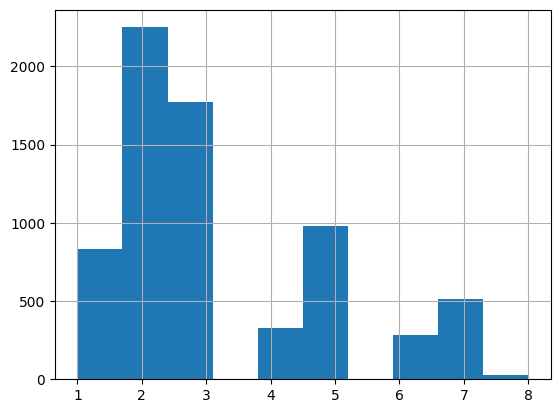

In [92]:
# ヒストグラムの確認
all_df["NumberOfTrips"].hist()

In [93]:
#########################
# "Passport"の処理 #
#########################
# all_df["Passport"].isnull().sum()
all_df["Passport"].value_counts()

,count
Passport,
0,6288
1,690


<Axes: >

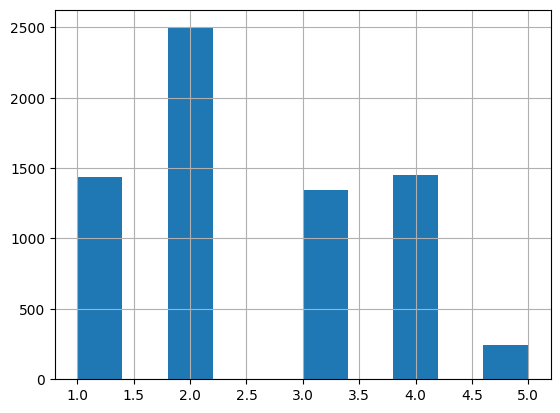

In [94]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
# all_df["PitchSatisfactionScore"].isnull().sum()
# all_df["PitchSatisfactionScore"].value_counts()
all_df["PitchSatisfactionScore"].hist()

In [95]:
#########################
# "Designation"の処理 #
#########################
# all_df["Designation"].isnull().sum()
# all_df["Designation"].value_counts()

In [96]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [97]:
# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

In [98]:
# 分類の確認
all_df["Designation"].value_counts()

,count
Designation,
Executive,2330
Manager,2117
Senior Manager,1632
AVP,635
VP,264


In [99]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

<Axes: >

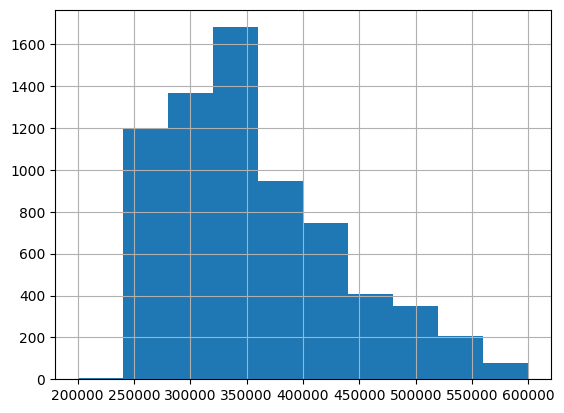

In [100]:
# 分布の確認
all_df["MonthlyIncome"].hist()

In [101]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [102]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [103]:
# 車保有率
all_df["CarHolder"].value_counts()

,count
CarHolder,
0,4408
1,2570


In [104]:
# 子供の数
all_df["NumofChild"].value_counts()

,count
NumofChild,
0,5015
1,1347
2,571
3,45


In [105]:
# 婚姻歴
all_df["Married"].value_counts()

,count
Married,
Married,2846
Single,2444
Divorce,1688


# 特徴量エンジニアリング

In [106]:
# 「Dsignation」をラベルエンコード
all_df["Designation_LE"] = 1
all_df.loc[all_df["Designation"]=="Executive","Designation_LE"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation_LE"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation_LE"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation_LE"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation_LE"] = 1

# 「Occupation」をラベルエンコード
all_df["Occupation_LE"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","Occupation_LE"] = 3
all_df.loc[all_df["Occupation"]=="Small Business","Occupation_LE"] = 2
all_df.loc[all_df["Occupation"]=="Salaried","Occupation_LE"] = 1

# 「CarHolder」をラベルエンコード
all_df["CarHolder_LE"] = all_df["CarHolder"] + 1

# 「Gender」をラベルエンコード
all_df["Gender_LE"] = 1
all_df.loc[all_df["Gender"]=="Female","Gender_LE"]=2
all_df.loc[all_df["Gender"]=="Male","Gender_LE"]=2

# 「ProductPitched」をラベルエンコード
all_df["ProductPitched_LE"] = 1
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched_LE"]=5
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched_LE"]=4
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched_LE"]=3
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched_LE"]=2
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched_LE"]=1

# 「Married」をラベルエンコード
all_df["Married_LE"] = 1
all_df.loc[all_df["Married"]=="Married","Married_LE"]=3
all_df.loc[all_df["Married"]=="Divorce","Married_LE"]=2
all_df.loc[all_df["Married"]=="Single","Married_LE"]=1

# 「TypeofContact」をラベルエンコード
all_df["TypeofContact_LE"] = 1
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact_LE"]=2
all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact_LE"]=1

In [107]:
# エンコード前のラベルを抹消する
all_df = all_df.drop("Designation", axis=1)
all_df = all_df.drop("Occupation", axis=1)
all_df = all_df.drop("Gender", axis=1)
all_df = all_df.drop("ProductPitched", axis=1)
all_df = all_df.drop("Married", axis=1)
all_df = all_df.drop("CarHolder", axis=1)
all_df = all_df.drop("TypeofContact", axis=1)

In [108]:
# 検討の結果、重要度が低いものを抹消する
# Occupation_LE, NumberOfFollowups, PreferredPropertyStar,Gender_LE
all_df = all_df.drop("Occupation_LE", axis=1)
all_df = all_df.drop("NumberOfFollowups", axis=1)
all_df = all_df.drop("PreferredPropertyStar", axis=1)
all_df = all_df.drop("Gender_LE", axis=1)

In [109]:
# 分布に偏りが見られそうなため、一つずつ確認していく

In [125]:
train = all_df.loc[0:len(train_df)-1]

<Axes: >

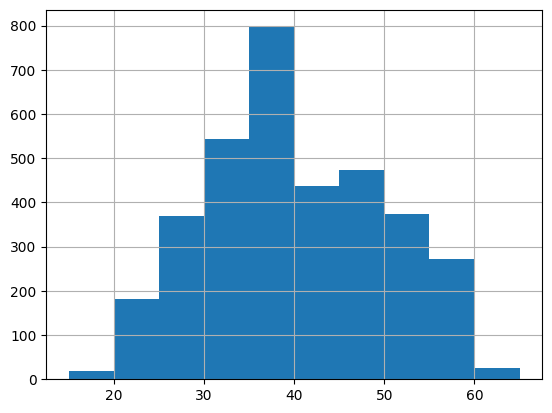

In [111]:
train["Age"].hist()

In [191]:
print(train.loc[train["Age"]<20,"ProdTaken"].mean())
print(train.loc[(train["Age"]>=20) & (train["Age"]<30),"ProdTaken"].mean())
print(train.loc[(train["Age"]>=30) & (train["Age"]<40),"ProdTaken"].mean())
print(train.loc[(train["Age"]>=40) & (train["Age"]<50),"ProdTaken"].mean())
print(train.loc[train["Age"]>=50,"ProdTaken"].mean())

0.5
0.30127041742286753
0.13965646004480955
0.08232711306256861
0.08955223880597014


<Axes: >

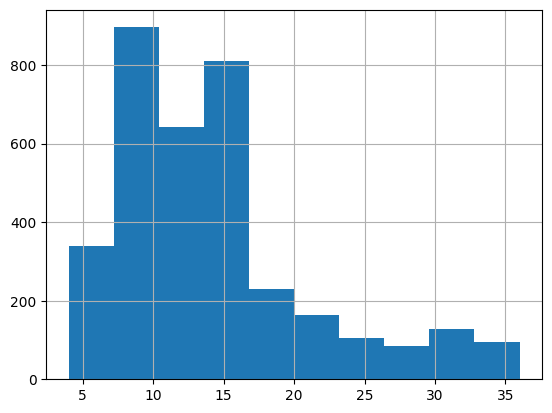

In [140]:
# DurationOfPitch [分]
train["DurationOfPitch"].hist()

In [151]:
# かけた時間と成功率に差はあるのか？
# 20分以上、10分以上、その他
# 対数変換する？
print(train.loc[train["DurationOfPitch"]>=15,"ProdTaken"].mean())
# print(train.loc[(train["DurationOfPitch"]>=10) & (train["DurationOfPitch"]<20),"ProdTaken"].mean())
# print(train.loc[train["DurationOfPitch"]<10,"ProdTaken"].mean())

0.14933135215453194


<Axes: >

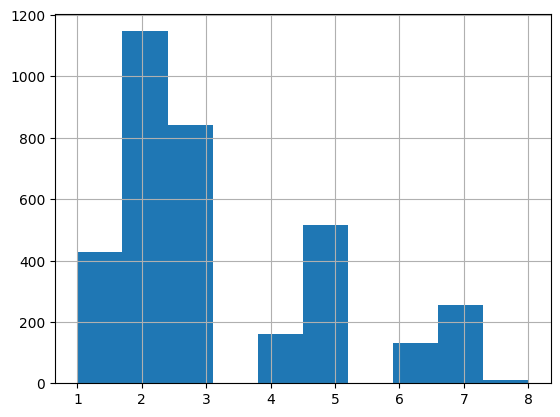

In [113]:
# NumberOfTrips
train["NumberOfTrips"].hist()

In [169]:
# 初回か6回以上の成功率が高い
print(train.loc[train["NumberOfTrips"]>=5,"ProdTaken"].mean())

# print(train.loc[train["NumberOfTrips"]>=6,"ProdTaken"].mean())
# print(train.loc[(train["NumberOfTrips"]>=3) & (train["NumberOfTrips"]<6),"ProdTaken"].mean())
# print(train.loc[train["NumberOfTrips"]<3,"ProdTaken"].mean())

0.13830954994511527


<Axes: >

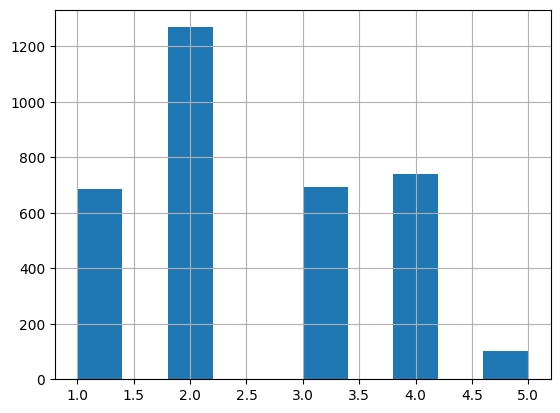

In [114]:
train["PitchSatisfactionScore"].hist()

In [174]:
# 2〜3が高い
print(train.loc[train["PitchSatisfactionScore"]==1,"ProdTaken"].mean())
print(train.loc[train["PitchSatisfactionScore"]==2,"ProdTaken"].mean())
print(train.loc[train["PitchSatisfactionScore"]==3,"ProdTaken"].mean())
print(train.loc[train["PitchSatisfactionScore"]==4,"ProdTaken"].mean())
print(train.loc[train["PitchSatisfactionScore"]==5,"ProdTaken"].mean())
# print(train.loc[(train["PitchSatisfactionScore"]<=3)&(train["PitchSatisfactionScore"]<2),"ProdTaken"].mean())

0.08017492711370262
0.17494089834515367
0.1416184971098266
0.15155615696887687
0.0970873786407767


<Axes: >

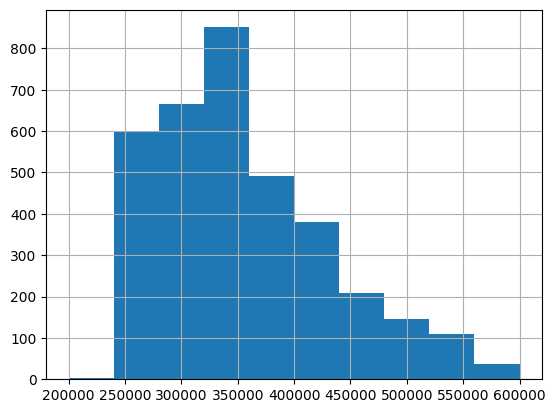

In [115]:
train["MonthlyIncome"].hist()

In [183]:
# Log取るか、月収低すぎを異常値とするか
print(train.loc[train["MonthlyIncome"]<250000,"ProdTaken"].mean())
print(train.loc[(train["MonthlyIncome"]>=250000)&(train["MonthlyIncome"]<300000),"ProdTaken"].mean())
print(train.loc[(train["MonthlyIncome"]>=300000)&(train["MonthlyIncome"]<350000),"ProdTaken"].mean())
print(train.loc[(train["MonthlyIncome"]>=350000)&(train["MonthlyIncome"]<400000),"ProdTaken"].mean())
print(train.loc[(train["MonthlyIncome"]>=400000)&(train["MonthlyIncome"]<450000),"ProdTaken"].mean())
print(train.loc[(train["MonthlyIncome"]>=450000)&(train["MonthlyIncome"]<500000),"ProdTaken"].mean())
print(train.loc[train["MonthlyIncome"]>=500000,"ProdTaken"].mean())

0.4444444444444444
0.3378995433789954
0.11547911547911548
0.06960227272727272
0.08256880733944955
0.06698564593301436
0.09787234042553192


<Axes: >

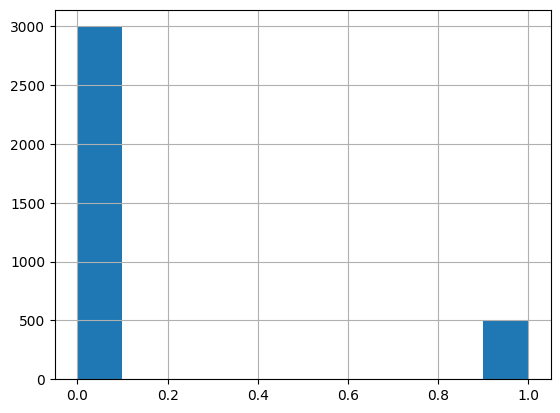

In [116]:
all_df["ProdTaken"].hist()

In [190]:
# 月収はLogを取る
all_df["MonthlyIncomeLOG"] = np.log1p(all_df["MonthlyIncome"])

In [192]:
# 年齢はLogを取る
all_df["AgeLOG"] = np.log1p(all_df["Age"])

In [193]:
all_df = all_df.drop("Age", axis=1)
all_df = all_df.drop("MonthlyIncome", axis=1)

In [194]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [195]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)

In [196]:
# カラムを制限
all_df2 = all_df[FEATURES]

In [197]:
# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

In [198]:
# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)

In [199]:
FEATURES = test.columns

In [200]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'regression',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'feature_fraction': 0.8619308173567727, # 7回
    'num_leaves': 122, # 20回
    'bagging_fraction': 0.4085996823085894,
    'bagging_freq': 1,
    'lambda_l1': 9.987613722346149,
    'lambda_l2': 1.1163643318267733,
    'min_data_in_leaf': 51,
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

In [201]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=26)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

#########################
### Fold 1
#########################
[100]	train's auc: 0.848687	valid's auc: 0.824461
[200]	train's auc: 0.853471	valid's auc: 0.825779
[300]	train's auc: 0.855901	valid's auc: 0.827446
#########################
### Fold 2
#########################
[100]	train's auc: 0.836111	valid's auc: 0.85576
[200]	train's auc: 0.843723	valid's auc: 0.856968
[300]	train's auc: 0.848541	valid's auc: 0.859204
[400]	train's auc: 0.850925	valid's auc: 0.859313
[500]	train's auc: 0.853237	valid's auc: 0.859379
#########################
### Fold 3
#########################
[100]	train's auc: 0.857744	valid's auc: 0.804084
[200]	train's auc: 0.862698	valid's auc: 0.808338
[300]	train's auc: 0.864817	valid's auc: 0.809388
[400]	train's auc: 0.867254	valid's auc: 0.810026
[500]	train's auc: 0.868982	valid's auc: 0.810305
[600]	train's auc: 0.870642	valid's auc: 0.810779
[700]	train's auc: 0.872665	valid's auc: 0.813044
0.8323362635707291
CPU times: user 8.76 s, sys: 726 ms, total:

In [202]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8323362635707291


In [ ]:
FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

skf_trainIND = []
skf_validIND = []

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
  skf_trainIND.append(train_index)
  skf_validIND.append(test_index)

In [ ]:
# FOLDごとのdfを分ける
train_FOLD1 = all_df.loc[skf_trainIND[0]]
train_FOLD2 = all_df.loc[skf_trainIND[2]]
train_FOLD3 = all_df.loc[skf_trainIND[4]]
test_FOLD1 = all_df.loc[skf_trainIND[1]]
test_FOLD2 = all_df.loc[skf_trainIND[3]]
test_FOLD3 = all_df.loc[skf_trainIND[5]]

In [ ]:
print(skf_trainIND[0])
print(skf_validIND[0])
print(skf_trainIND[1])
print(skf_validIND[1])
print(skf_trainIND[2])
print(skf_validIND[2])

[   0    3    4 ... 3485 3486 3488]
[   1    2   16 ... 3478 3480 3487]
[   0    1    2 ... 3485 3487 3488]
[   3    4    5 ... 3482 3483 3486]
[   1    2    3 ... 3483 3486 3487]
[   0    6   13 ... 3484 3485 3488]


In [ ]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8267038729704431


In [ ]:
# FOLD1
# lgb.plot_importance(models[0], figsize=(8,4), max_num_features=20, importance_type='gain')
importance0 = pd.DataFrame(models[0].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance1 = pd.DataFrame(models[1].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance2 = pd.DataFrame(models[2].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])

In [ ]:
feature = (importance0+importance1+importance2)/3

In [ ]:
# feature.sort_values("importance", ascending=False)

,importance
ProductPitched_LE,87.508120
Designation_LE,71.270709
Married_LE,42.266528
Passport,40.617540
MonthlyIncome,36.971274
Age,21.162398
CityTier,19.658866
PitchSatisfactionScore,5.633341
DurationOfPitch,5.458489
NumberOfTrips,5.212784


In [ ]:
!pip install shap

In [ ]:
import shap
shap.initjs()
# 基本スコア
explainer = shap.TreeExplainer(model=models[0])

[0.14114727]


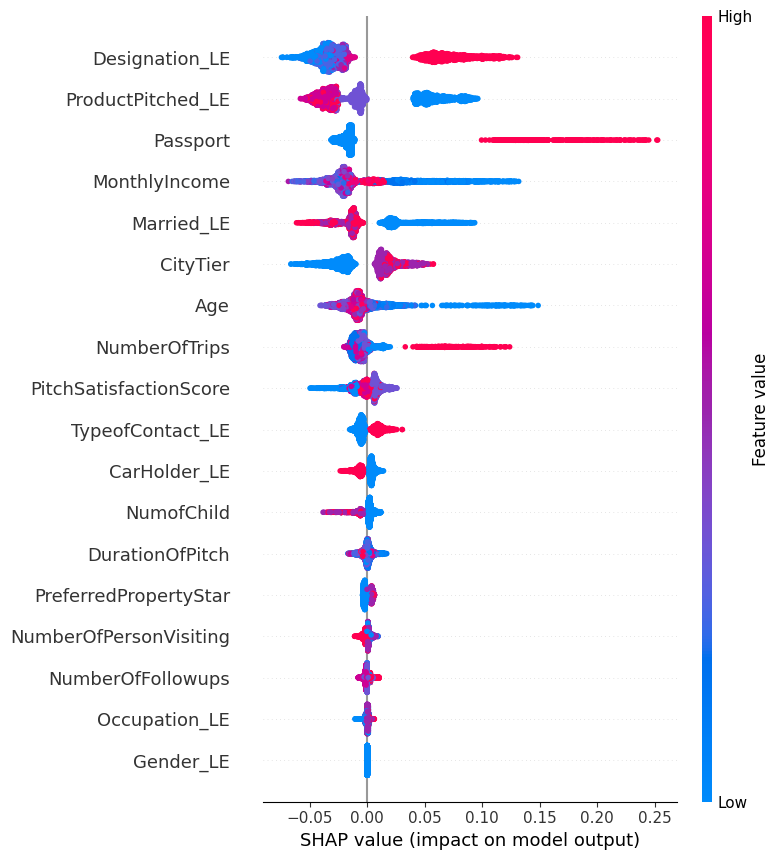

In [ ]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt

# 学習済みのモデル（例：lgb_model）
# 学習に使った特徴量データ（例：X_train）

# 横軸：SHAP値 (0からの貢献度、右=プラスの影響)
# 縦軸：特徴量 (上にあるほど重要)
# 色：その特徴の値 (赤=大きい値、青=小さい値)

# ① SHAPのexplainerを作成
explainer = shap.TreeExplainer(models[0])

# ② SHAP値を計算（X_trainは学習に使った特徴量データ）
shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))

# ③ summary plotで全体の重要度と分布を見る
shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

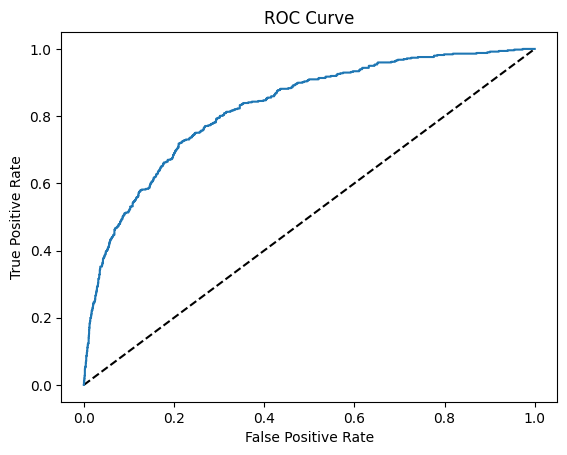

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
!pip install optuna

In [ ]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

def objective(trial):

  lgbm_params = {
      'objective': 'regression',
      "device": "cpu",
      'metric': 'auc',
      # 'metric': 'rmse',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
      'num_leaves': trial.suggest_int('num_leaves', 2, 256), # 20回
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      # 'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1), # 2回目
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
      # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      # 'max_depth': trial.suggest_int('max_depth', 3, 12),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])


    # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    # models.append(model_lgb)
    # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

  # pred_lgb = []
  # # 予測
  # for model in models:
  #   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

  # pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

  # pred_lgb /= FOLDS
  # score = roc_auc_score(train[TARGET],oof_lgb)

  score = roc_auc_score(train[TARGET],oof_lgb)


  # mse = mean_squared_error(train[TARGET], oof_lgb)
  # rmse = np.sqrt(mse)  # MSEの平方根を取ってRMSEを計算


  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-20 12:55:45,926] A new study created in memory with name: no-name-31d6687c-0d06-45b0-bc84-703e0ab5bf33
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.918562	valid's auc: 0.82535
#########################
### Fold 2
#########################
[100]	train's auc: 0.92397	valid's auc: 0.785271
#########################
### Fold 3
#########################
[100]	train's auc: 0.915367	valid's auc: 0.817265


[I 2025-05-20 12:55:46,440] Trial 0 finished with value: 0.8137040827854829 and parameters: {'feature_fraction': 0.9166340005374704, 'num_leaves': 13, 'bagging_fraction': 0.7269351379972162, 'bagging_freq': 7, 'lambda_l1': 2.4459265862272055, 'lambda_l2': 7.373044335578581, 'min_data_in_leaf': 17}. Best is trial 0 with value: 0.8137040827854829.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.880921	valid's auc: 0.834939
#########################
### Fold 2
#########################
[100]	train's auc: 0.891157	valid's auc: 0.800885
#########################
### Fold 3
#########################
[100]	train's auc: 0.880672	valid's auc: 0.832131


[I 2025-05-20 12:55:47,063] Trial 1 finished with value: 0.8223512196171683 and parameters: {'feature_fraction': 0.627409738364987, 'num_leaves': 143, 'bagging_fraction': 0.7565989312131214, 'bagging_freq': 6, 'lambda_l1': 4.141766368430562, 'lambda_l2': 5.094296041619345, 'min_data_in_leaf': 69}. Best is trial 1 with value: 0.8223512196171683.


[200]	train's auc: 0.896639	valid's auc: 0.828275
#########################
### Fold 1
#########################
[100]	train's auc: 0.924094	valid's auc: 0.819096
#########################
### Fold 2
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.932519	valid's auc: 0.796649
#########################
### Fold 3
#########################


[I 2025-05-20 12:55:47,720] Trial 2 finished with value: 0.8178294365121209 and parameters: {'feature_fraction': 0.4223307600949741, 'num_leaves': 62, 'bagging_fraction': 0.5519057641805794, 'bagging_freq': 1, 'lambda_l1': 2.119894733773093, 'lambda_l2': 1.802689166937742, 'min_data_in_leaf': 12}. Best is trial 1 with value: 0.8223512196171683.


[100]	train's auc: 0.926943	valid's auc: 0.81789
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.878356	valid's auc: 0.832769
#########################
### Fold 2
#########################
[100]	train's auc: 0.893513	valid's auc: 0.801857
#########################
### Fold 3
#########################


[I 2025-05-20 12:55:48,200] Trial 3 finished with value: 0.8183021928361613 and parameters: {'feature_fraction': 0.9302556123341011, 'num_leaves': 26, 'bagging_fraction': 0.9661710147577106, 'bagging_freq': 3, 'lambda_l1': 7.657556223669232, 'lambda_l2': 1.7935424479745161, 'min_data_in_leaf': 9}. Best is trial 1 with value: 0.8223512196171683.


[100]	train's auc: 0.880597	valid's auc: 0.82488
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.934561	valid's auc: 0.821664
#########################
### Fold 2
#########################
[100]	train's auc: 0.938579	valid's auc: 0.786601
#########################
### Fold 3
#########################
[100]	train's auc: 0.934525	valid's auc: 0.821491


[I 2025-05-20 12:55:48,852] Trial 4 finished with value: 0.8115487712370478 and parameters: {'feature_fraction': 0.43053335409366605, 'num_leaves': 36, 'bagging_fraction': 0.8632922785629251, 'bagging_freq': 3, 'lambda_l1': 1.7398714410250828, 'lambda_l2': 8.393388812557697, 'min_data_in_leaf': 31}. Best is trial 1 with value: 0.8223512196171683.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.848464	valid's auc: 0.843192
[200]	train's auc: 0.854902	valid's auc: 0.84576
#########################
### Fold 2
#########################
[100]	train's auc: 0.868417	valid's auc: 0.80164
[200]	train's auc: 0.871569	valid's auc: 0.804588
#########################
### Fold 3
#########################
[100]	train's auc: 0.848886	valid's auc: 0.833072
[200]	train's auc: 0.855176	valid's auc: 0.8334


[I 2025-05-20 12:55:49,576] Trial 5 finished with value: 0.8265455029643101 and parameters: {'feature_fraction': 0.6066459550494854, 'num_leaves': 193, 'bagging_fraction': 0.6851471219200489, 'bagging_freq': 2, 'lambda_l1': 8.879769826100295, 'lambda_l2': 3.233746049775665, 'min_data_in_leaf': 70}. Best is trial 5 with value: 0.8265455029643101.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.868955	valid's auc: 0.823168
#########################
### Fold 2
#########################
[100]	train's auc: 0.882763	valid's auc: 0.798462
#########################
### Fold 3
#########################
[100]	train's auc: 0.875017	valid's auc: 0.820562


[I 2025-05-20 12:55:50,109] Trial 6 finished with value: 0.8159027695585276 and parameters: {'feature_fraction': 0.9485868064857907, 'num_leaves': 226, 'bagging_fraction': 0.6396455138042719, 'bagging_freq': 7, 'lambda_l1': 5.8656752250217865, 'lambda_l2': 5.961827544218989, 'min_data_in_leaf': 39}. Best is trial 5 with value: 0.8265455029643101.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.846813	valid's auc: 0.840564
[200]	train's auc: 0.856474	valid's auc: 0.839682
#########################
### Fold 2
#########################
[100]	train's auc: 0.867851	valid's auc: 0.805199
[200]	train's auc: 0.874752	valid's auc: 0.80819
[300]	train's auc: 0.878099	valid's auc: 0.808945
#########################
### Fold 3
#########################
[100]	train's auc: 0.855323	valid's auc: 0.832447


[I 2025-05-20 12:55:50,883] Trial 7 finished with value: 0.8264352155715039 and parameters: {'feature_fraction': 0.41059087329392896, 'num_leaves': 163, 'bagging_fraction': 0.5107595565435643, 'bagging_freq': 6, 'lambda_l1': 7.737540643053494, 'lambda_l2': 1.1706601221337167, 'min_data_in_leaf': 14}. Best is trial 5 with value: 0.8265455029643101.


[200]	train's auc: 0.860704	valid's auc: 0.831669
#########################
### Fold 1
#########################
[100]	train's auc: 0.845785	valid's auc: 0.842751


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.851714	valid's auc: 0.841845
#########################
### Fold 2
#########################
[100]	train's auc: 0.864357	valid's auc: 0.803912
[200]	train's auc: 0.868243	valid's auc: 0.805833
[300]	train's auc: 0.869971	valid's auc: 0.805869
#########################
### Fold 3
#########################
[100]	train's auc: 0.848425	valid's auc: 0.830385


[I 2025-05-20 12:55:51,624] Trial 8 finished with value: 0.8262973563304964 and parameters: {'feature_fraction': 0.4300144241867945, 'num_leaves': 209, 'bagging_fraction': 0.7385856448287395, 'bagging_freq': 6, 'lambda_l1': 8.218120755959953, 'lambda_l2': 8.73747953227704, 'min_data_in_leaf': 97}. Best is trial 5 with value: 0.8265455029643101.


[200]	train's auc: 0.851797	valid's auc: 0.83323
#########################
### Fold 1
#########################
[100]	train's auc: 0.894181	valid's auc: 0.837506


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.903967	valid's auc: 0.799434
[200]	train's auc: 0.912281	valid's auc: 0.801652
#########################
### Fold 3
#########################


[I 2025-05-20 12:55:53,907] Trial 9 finished with value: 0.8226370253607204 and parameters: {'feature_fraction': 0.6360751379920093, 'num_leaves': 127, 'bagging_fraction': 0.9311558963700344, 'bagging_freq': 4, 'lambda_l1': 4.863739167359568, 'lambda_l2': 4.1650529165656085, 'min_data_in_leaf': 32}. Best is trial 5 with value: 0.8265455029643101.


[100]	train's auc: 0.89529	valid's auc: 0.826805
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.840581	valid's auc: 0.846935
[200]	train's auc: 0.845761	valid's auc: 0.848256
[300]	train's auc: 0.849418	valid's auc: 0.849102
#########################
### Fold 2
#########################
[100]	train's auc: 0.857899	valid's auc: 0.80573
[200]	train's auc: 0.862953	valid's auc: 0.807845
[300]	train's auc: 0.866029	valid's auc: 0.809332
#########################
### Fold 3
#########################
[100]	train's auc: 0.847882	valid's auc: 0.827072


[I 2025-05-20 12:55:54,853] Trial 10 finished with value: 0.828503104186617 and parameters: {'feature_fraction': 0.7624359040612634, 'num_leaves': 101, 'bagging_fraction': 0.4260694556482217, 'bagging_freq': 1, 'lambda_l1': 9.710401607565377, 'lambda_l2': 3.5374747012493497, 'min_data_in_leaf': 69}. Best is trial 10 with value: 0.828503104186617.


[200]	train's auc: 0.853799	valid's auc: 0.83252
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.839957	valid's auc: 0.849201
[200]	train's auc: 0.844944	valid's auc: 0.850612
[300]	train's auc: 0.848961	valid's auc: 0.850376
#########################
### Fold 2
#########################
[100]	train's auc: 0.857559	valid's auc: 0.805604
[200]	train's auc: 0.862231	valid's auc: 0.806788
[300]	train's auc: 0.865081	valid's auc: 0.807664
#########################
### Fold 3
#########################
[100]	train's auc: 0.846716	valid's auc: 0.827698
[200]	train's auc: 0.852623	valid's auc: 0.83252
[300]	train's auc: 0.855033	valid's auc: 0.833339
[400]	train's auc: 0.857323	valid's auc: 0.83569
[500]	train's auc: 0.859488	valid's auc: 0.834724


[I 2025-05-20 12:55:55,988] Trial 11 finished with value: 0.8290814405147462 and parameters: {'feature_fraction': 0.7697877462663988, 'num_leaves': 98, 'bagging_fraction': 0.42116003134781504, 'bagging_freq': 1, 'lambda_l1': 9.907925220634732, 'lambda_l2': 3.425680334256506, 'min_data_in_leaf': 68}. Best is trial 11 with value: 0.8290814405147462.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.841144	valid's auc: 0.848074
[200]	train's auc: 0.847021	valid's auc: 0.84924
[300]	train's auc: 0.851016	valid's auc: 0.849591
#########################
### Fold 2
#########################
[100]	train's auc: 0.857498	valid's auc: 0.804066
[200]	train's auc: 0.8629	valid's auc: 0.806172
[300]	train's auc: 0.865991	valid's auc: 0.807924
[400]	train's auc: 0.868711	valid's auc: 0.808667
[500]	train's auc: 0.87162	valid's auc: 0.808329
#########################
### Fold 3
#########################
[100]	train's auc: 0.8467	valid's auc: 0.825718


[I 2025-05-20 12:55:57,062] Trial 12 finished with value: 0.8271910877026867 and parameters: {'feature_fraction': 0.7960969837586134, 'num_leaves': 98, 'bagging_fraction': 0.41384864368857577, 'bagging_freq': 1, 'lambda_l1': 9.51159395588966, 'lambda_l2': 3.2816231956886437, 'min_data_in_leaf': 66}. Best is trial 11 with value: 0.8290814405147462.


[200]	train's auc: 0.8522	valid's auc: 0.829368
#########################
### Fold 1
#########################
[100]	train's auc: 0.837864	valid's auc: 0.845754


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.842397	valid's auc: 0.846908
#########################
### Fold 2
#########################
[100]	train's auc: 0.855417	valid's auc: 0.806649
[200]	train's auc: 0.859696	valid's auc: 0.807181
[300]	train's auc: 0.86334	valid's auc: 0.809839
[400]	train's auc: 0.865787	valid's auc: 0.81077
[500]	train's auc: 0.86774	valid's auc: 0.812474
#########################
### Fold 3
#########################
[100]	train's auc: 0.842385	valid's auc: 0.821203


[I 2025-05-20 12:55:58,033] Trial 13 finished with value: 0.8274029201949666 and parameters: {'feature_fraction': 0.7675089454594799, 'num_leaves': 88, 'bagging_fraction': 0.40119674649991566, 'bagging_freq': 2, 'lambda_l1': 9.81887449203694, 'lambda_l2': 0.09161289745246926, 'min_data_in_leaf': 86}. Best is trial 11 with value: 0.8290814405147462.


[200]	train's auc: 0.84658	valid's auc: 0.828718
#########################
### Fold 1
#########################
[100]	train's auc: 0.858362	valid's auc: 0.846473


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.873542	valid's auc: 0.804643
[200]	train's auc: 0.884227	valid's auc: 0.806661
[300]	train's auc: 0.891585	valid's auc: 0.807193
#########################
### Fold 3
#########################
[100]	train's auc: 0.858267	valid's auc: 0.828639


[I 2025-05-20 12:55:58,802] Trial 14 finished with value: 0.8270263290975801 and parameters: {'feature_fraction': 0.8199312203005271, 'num_leaves': 105, 'bagging_fraction': 0.511015825637864, 'bagging_freq': 1, 'lambda_l1': 6.451478529192391, 'lambda_l2': 5.831222294290242, 'min_data_in_leaf': 54}. Best is trial 11 with value: 0.8290814405147462.


[200]	train's auc: 0.869065	valid's auc: 0.830916
#########################
### Fold 1
#########################
[100]	train's auc: 0.904398	valid's auc: 0.825772


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.90959	valid's auc: 0.793549


[I 2025-05-20 12:55:59,368] Trial 15 finished with value: 0.8196481697672667 and parameters: {'feature_fraction': 0.7199008935259957, 'num_leaves': 69, 'bagging_fraction': 0.5866296074683303, 'bagging_freq': 2, 'lambda_l1': 0.11699790092764673, 'lambda_l2': 4.004490520036099, 'min_data_in_leaf': 81}. Best is trial 11 with value: 0.8290814405147462.


#########################
### Fold 3
#########################
[100]	train's auc: 0.907441	valid's auc: 0.821637


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.852454	valid's auc: 0.838389
#########################
### Fold 2
#########################
[100]	train's auc: 0.866794	valid's auc: 0.802552
[200]	train's auc: 0.87611	valid's auc: 0.804999
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:00,036] Trial 16 finished with value: 0.8233427974262688 and parameters: {'feature_fraction': 0.8400624478834757, 'num_leaves': 160, 'bagging_fraction': 0.47594915890513345, 'bagging_freq': 4, 'lambda_l1': 6.91217036070302, 'lambda_l2': 2.6946281654989903, 'min_data_in_leaf': 53}. Best is trial 11 with value: 0.8290814405147462.


[100]	train's auc: 0.854043	valid's auc: 0.827719
[200]	train's auc: 0.860197	valid's auc: 0.82522
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.835457	valid's auc: 0.846558
[200]	train's auc: 0.83742	valid's auc: 0.846981
#########################
### Fold 2
#########################
[100]	train's auc: 0.85488	valid's auc: 0.801105
[200]	train's auc: 0.861002	valid's auc: 0.805688
[300]	train's auc: 0.863683	valid's auc: 0.807567
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:00,748] Trial 17 finished with value: 0.8241998784148742 and parameters: {'feature_fraction': 0.5368258642614971, 'num_leaves': 123, 'bagging_fraction': 0.46388743754788275, 'bagging_freq': 3, 'lambda_l1': 9.801725299608544, 'lambda_l2': 9.985672191312112, 'min_data_in_leaf': 81}. Best is trial 11 with value: 0.8290814405147462.


[100]	train's auc: 0.843806	valid's auc: 0.820836
[200]	train's auc: 0.845305	valid's auc: 0.823556
#########################
### Fold 1
#########################
[100]	train's auc: 0.845912	valid's auc: 0.846812


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.85321	valid's auc: 0.845301
#########################
### Fold 2
#########################
[100]	train's auc: 0.862973	valid's auc: 0.805483
[200]	train's auc: 0.869324	valid's auc: 0.806486
#########################
### Fold 3
#########################
[100]	train's auc: 0.850669	valid's auc: 0.830783


[I 2025-05-20 12:56:01,463] Trial 18 finished with value: 0.8262469200228106 and parameters: {'feature_fraction': 0.6924047687633341, 'num_leaves': 250, 'bagging_fraction': 0.6126545772759145, 'bagging_freq': 1, 'lambda_l1': 8.53093684617334, 'lambda_l2': 6.295708803403577, 'min_data_in_leaf': 100}. Best is trial 11 with value: 0.8290814405147462.


[200]	train's auc: 0.856026	valid's auc: 0.829781
#########################
### Fold 1
#########################
[100]	train's auc: 0.892871	valid's auc: 0.833929


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.905234	valid's auc: 0.795289


[I 2025-05-20 12:56:02,057] Trial 19 finished with value: 0.817808253262893 and parameters: {'feature_fraction': 0.8585016581610347, 'num_leaves': 57, 'bagging_fraction': 0.8049935352017552, 'bagging_freq': 2, 'lambda_l1': 4.141527932970923, 'lambda_l2': 4.450315476996685, 'min_data_in_leaf': 61}. Best is trial 11 with value: 0.8290814405147462.


#########################
### Fold 3
#########################
[100]	train's auc: 0.895021	valid's auc: 0.823083
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.854154	valid's auc: 0.837156
[200]	train's auc: 0.866311	valid's auc: 0.839289
[300]	train's auc: 0.87338	valid's auc: 0.838733
#########################
### Fold 2
#########################
[100]	train's auc: 0.866008	valid's auc: 0.795782
[200]	train's auc: 0.877326	valid's auc: 0.798513
[300]	train's auc: 0.884335	valid's auc: 0.796842
#########################
### Fold 3
#########################
[100]	train's auc: 0.859851	valid's auc: 0.826007
[200]	train's auc: 0.870283	valid's auc: 0.823119


[I 2025-05-20 12:56:02,930] Trial 20 finished with value: 0.8213576243557602 and parameters: {'feature_fraction': 0.9946852716385248, 'num_leaves': 163, 'bagging_fraction': 0.4455141745163278, 'bagging_freq': 3, 'lambda_l1': 7.225534689062205, 'lambda_l2': 0.16224952659490377, 'min_data_in_leaf': 46}. Best is trial 11 with value: 0.8290814405147462.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.837517	valid's auc: 0.844793
[200]	train's auc: 0.843818	valid's auc: 0.84628
[300]	train's auc: 0.846442	valid's auc: 0.845978
#########################
### Fold 2
#########################
[100]	train's auc: 0.85517	valid's auc: 0.803851
[200]	train's auc: 0.855747	valid's auc: 0.804341
#########################
### Fold 3
#########################
[100]	train's auc: 0.841352	valid's auc: 0.827145


[I 2025-05-20 12:56:05,252] Trial 21 finished with value: 0.8266705850073705 and parameters: {'feature_fraction': 0.7513173657430596, 'num_leaves': 92, 'bagging_fraction': 0.41036803302088076, 'bagging_freq': 2, 'lambda_l1': 9.961390779022013, 'lambda_l2': 2.3947555544063923, 'min_data_in_leaf': 88}. Best is trial 11 with value: 0.8290814405147462.


[200]	train's auc: 0.845753	valid's auc: 0.831584
#########################
### Fold 1
#########################
[100]	train's auc: 0.839741	valid's auc: 0.850491


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.846064	valid's auc: 0.851929
[300]	train's auc: 0.850104	valid's auc: 0.849784
#########################
### Fold 2
#########################
[100]	train's auc: 0.856108	valid's auc: 0.807063
[200]	train's auc: 0.861242	valid's auc: 0.808268
[300]	train's auc: 0.864398	valid's auc: 0.811096
#########################
### Fold 3
#########################
[100]	train's auc: 0.845282	valid's auc: 0.825457
[200]	train's auc: 0.852326	valid's auc: 0.828888
[300]	train's auc: 0.855249	valid's auc: 0.829696


[I 2025-05-20 12:56:06,385] Trial 22 finished with value: 0.8294439094459806 and parameters: {'feature_fraction': 0.7673930834169137, 'num_leaves': 86, 'bagging_fraction': 0.40646481079438246, 'bagging_freq': 1, 'lambda_l1': 8.949767723862845, 'lambda_l2': 0.47948811968375615, 'min_data_in_leaf': 81}. Best is trial 22 with value: 0.8294439094459806.


[400]	train's auc: 0.856731	valid's auc: 0.831141
[500]	train's auc: 0.859659	valid's auc: 0.829981
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.844515	valid's auc: 0.84834
#########################
### Fold 2
#########################
[100]	train's auc: 0.862314	valid's auc: 0.801392
[200]	train's auc: 0.867808	valid's auc: 0.802462
[300]	train's auc: 0.871196	valid's auc: 0.805724
[400]	train's auc: 0.873512	valid's auc: 0.805936
[500]	train's auc: 0.875865	valid's auc: 0.805054
#########################
### Fold 3
#########################
[100]	train's auc: 0.851006	valid's auc: 0.828199
[200]	train's auc: 0.855837	valid's auc: 0.829659


[I 2025-05-20 12:56:07,516] Trial 23 finished with value: 0.8259940660002798 and parameters: {'feature_fraction': 0.6879158649858228, 'num_leaves': 75, 'bagging_fraction': 0.530707306565463, 'bagging_freq': 1, 'lambda_l1': 8.889023541598224, 'lambda_l2': 1.659959772136732, 'min_data_in_leaf': 75}. Best is trial 22 with value: 0.8294439094459806.


[300]	train's auc: 0.858713	valid's auc: 0.831153
[400]	train's auc: 0.861515	valid's auc: 0.831584
[500]	train's auc: 0.863943	valid's auc: 0.831445


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.847584	valid's auc: 0.847343
[200]	train's auc: 0.854154	valid's auc: 0.84492
#########################
### Fold 2
#########################
[100]	train's auc: 0.862883	valid's auc: 0.805196
[200]	train's auc: 0.86877	valid's auc: 0.80738
[300]	train's auc: 0.873459	valid's auc: 0.809078
[400]	train's auc: 0.876689	valid's auc: 0.809658
[500]	train's auc: 0.878576	valid's auc: 0.809235
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:08,516] Trial 24 finished with value: 0.8276793111610841 and parameters: {'feature_fraction': 0.8677790134943, 'num_leaves': 114, 'bagging_fraction': 0.4790797639436841, 'bagging_freq': 1, 'lambda_l1': 8.945364350273925, 'lambda_l2': 1.1202681782371806, 'min_data_in_leaf': 63}. Best is trial 22 with value: 0.8294439094459806.


[100]	train's auc: 0.851295	valid's auc: 0.829857
[200]	train's auc: 0.857041	valid's auc: 0.83119


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.855703	valid's auc: 0.841005
#########################
### Fold 2
#########################
[100]	train's auc: 0.871947	valid's auc: 0.798468
#########################
### Fold 3
#########################
[100]	train's auc: 0.86053	valid's auc: 0.828852


[I 2025-05-20 12:56:09,118] Trial 25 finished with value: 0.8217762457095514 and parameters: {'feature_fraction': 0.7650169617248217, 'num_leaves': 45, 'bagging_fraction': 0.565991050150146, 'bagging_freq': 4, 'lambda_l1': 5.9880084871871135, 'lambda_l2': 3.4019567716925185, 'min_data_in_leaf': 76}. Best is trial 22 with value: 0.8294439094459806.


[200]	train's auc: 0.86944	valid's auc: 0.822815
#########################
### Fold 1
#########################
[100]	train's auc: 0.838612	valid's auc: 0.846987


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.846826	valid's auc: 0.848793
#########################
### Fold 2
#########################
[100]	train's auc: 0.85802	valid's auc: 0.801942
[200]	train's auc: 0.86343	valid's auc: 0.806262
#########################
### Fold 3
#########################
[100]	train's auc: 0.84611	valid's auc: 0.828997
[200]	train's auc: 0.848659	valid's auc: 0.831329


[I 2025-05-20 12:56:09,794] Trial 26 finished with value: 0.8271641883385876 and parameters: {'feature_fraction': 0.7118635073810419, 'num_leaves': 137, 'bagging_fraction': 0.44301022273138074, 'bagging_freq': 2, 'lambda_l1': 8.30546602108662, 'lambda_l2': 5.070645827931938, 'min_data_in_leaf': 91}. Best is trial 22 with value: 0.8294439094459806.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.846367	valid's auc: 0.836884
[200]	train's auc: 0.848028	valid's auc: 0.837271
#########################
### Fold 2
#########################
[100]	train's auc: 0.864444	valid's auc: 0.801658
[200]	train's auc: 0.868331	valid's auc: 0.80319
#########################
### Fold 3
#########################
[100]	train's auc: 0.851014	valid's auc: 0.830467


[I 2025-05-20 12:56:10,536] Trial 27 finished with value: 0.8232298200970529 and parameters: {'feature_fraction': 0.5840807686576815, 'num_leaves': 81, 'bagging_fraction': 0.6707114119849616, 'bagging_freq': 5, 'lambda_l1': 9.094396263592749, 'lambda_l2': 1.0607395972832512, 'min_data_in_leaf': 61}. Best is trial 22 with value: 0.8294439094459806.


[200]	train's auc: 0.85367	valid's auc: 0.832343
[300]	train's auc: 0.856555	valid's auc: 0.83436
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.847253	valid's auc: 0.851398
#########################
### Fold 2
#########################
[100]	train's auc: 0.867354	valid's auc: 0.80393
[200]	train's auc: 0.874529	valid's auc: 0.806045
[300]	train's auc: 0.879522	valid's auc: 0.806921
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:11,328] Trial 28 finished with value: 0.8271107258524408 and parameters: {'feature_fraction': 0.8010432606871666, 'num_leaves': 50, 'bagging_fraction': 0.4924431303665121, 'bagging_freq': 1, 'lambda_l1': 7.650138158254537, 'lambda_l2': 2.479170827533278, 'min_data_in_leaf': 76}. Best is trial 22 with value: 0.8294439094459806.


[100]	train's auc: 0.853384	valid's auc: 0.828903
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.844375	valid's auc: 0.847917
[200]	train's auc: 0.852323	valid's auc: 0.84744
#########################
### Fold 2
#########################
[100]	train's auc: 0.862062	valid's auc: 0.805362
[200]	train's auc: 0.868223	valid's auc: 0.80893
[300]	train's auc: 0.872188	valid's auc: 0.80961
#########################
### Fold 3
#########################
[100]	train's auc: 0.848462	valid's auc: 0.827163
[200]	train's auc: 0.855499	valid's auc: 0.830194


[I 2025-05-20 12:56:12,159] Trial 29 finished with value: 0.8270431412001422 and parameters: {'feature_fraction': 0.8901072935604271, 'num_leaves': 13, 'bagging_fraction': 0.44590484161585936, 'bagging_freq': 2, 'lambda_l1': 9.449549936481334, 'lambda_l2': 6.976556946215602, 'min_data_in_leaf': 47}. Best is trial 22 with value: 0.8294439094459806.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.844897	valid's auc: 0.84892
[200]	train's auc: 0.851943	valid's auc: 0.848237
#########################
### Fold 2
#########################
[100]	train's auc: 0.864521	valid's auc: 0.80003
[200]	train's auc: 0.870628	valid's auc: 0.805114
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:12,817] Trial 30 finished with value: 0.827519259944695 and parameters: {'feature_fraction': 0.6617693467868178, 'num_leaves': 109, 'bagging_fraction': 0.5986960399021627, 'bagging_freq': 3, 'lambda_l1': 8.202204085310717, 'lambda_l2': 4.556827570997223, 'min_data_in_leaf': 93}. Best is trial 22 with value: 0.8294439094459806.


[100]	train's auc: 0.850065	valid's auc: 0.833042
[200]	train's auc: 0.855843	valid's auc: 0.833831
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.843201	valid's auc: 0.847174
[200]	train's auc: 0.848402	valid's auc: 0.84889
[300]	train's auc: 0.853103	valid's auc: 0.847585
#########################
### Fold 2
#########################
[100]	train's auc: 0.857506	valid's auc: 0.806184
[200]	train's auc: 0.863226	valid's auc: 0.807597
[300]	train's auc: 0.867263	valid's auc: 0.810371
[400]	train's auc: 0.870353	valid's auc: 0.809742
#########################
### Fold 3
#########################
[100]	train's auc: 0.848894	valid's auc: 0.829659


[I 2025-05-20 12:56:13,778] Trial 31 finished with value: 0.8285905271199387 and parameters: {'feature_fraction': 0.8763306925642133, 'num_leaves': 116, 'bagging_fraction': 0.4023081260202856, 'bagging_freq': 1, 'lambda_l1': 9.230670485662174, 'lambda_l2': 0.8880719197303854, 'min_data_in_leaf': 61}. Best is trial 22 with value: 0.8294439094459806.


[200]	train's auc: 0.854561	valid's auc: 0.83306
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.840929	valid's auc: 0.85066
[200]	train's auc: 0.847324	valid's auc: 0.85121
[300]	train's auc: 0.85185	valid's auc: 0.851482
#########################
### Fold 2
#########################
[100]	train's auc: 0.856788	valid's auc: 0.804374
[200]	train's auc: 0.863541	valid's auc: 0.807718
[300]	train's auc: 0.866709	valid's auc: 0.81031
#########################
### Fold 3
#########################
[100]	train's auc: 0.84848	valid's auc: 0.827947


[I 2025-05-20 12:56:15,018] Trial 32 finished with value: 0.8284667900450834 and parameters: {'feature_fraction': 0.8931450935121829, 'num_leaves': 139, 'bagging_fraction': 0.40257815622446624, 'bagging_freq': 1, 'lambda_l1': 9.938895219178333, 'lambda_l2': 0.6044628807304794, 'min_data_in_leaf': 57}. Best is trial 22 with value: 0.8294439094459806.


[200]	train's auc: 0.854965	valid's auc: 0.832064
[300]	train's auc: 0.856873	valid's auc: 0.831275
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.84504	valid's auc: 0.846509
[200]	train's auc: 0.850443	valid's auc: 0.845222
#########################
### Fold 2
#########################
[100]	train's auc: 0.862598	valid's auc: 0.802298
[200]	train's auc: 0.868064	valid's auc: 0.804474
[300]	train's auc: 0.87097	valid's auc: 0.807078
[400]	train's auc: 0.873569	valid's auc: 0.807531
[500]	train's auc: 0.875686	valid's auc: 0.806848
#########################
### Fold 3
#########################
[100]	train's auc: 0.85132	valid's auc: 0.829006
[200]	train's auc: 0.855873	valid's auc: 0.831924
[300]	train's auc: 0.858805	valid's auc: 0.832028


[I 2025-05-20 12:56:18,018] Trial 33 finished with value: 0.8273753483467651 and parameters: {'feature_fraction': 0.7387626585660172, 'num_leaves': 153, 'bagging_fraction': 0.5353407942881601, 'bagging_freq': 1, 'lambda_l1': 9.309502298090854, 'lambda_l2': 2.133678721937148, 'min_data_in_leaf': 72}. Best is trial 22 with value: 0.8294439094459806.


[400]	train's auc: 0.861021	valid's auc: 0.833133
[500]	train's auc: 0.863484	valid's auc: 0.83337
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.866509	valid's auc: 0.841259
#########################
### Fold 2
#########################
[100]	train's auc: 0.879275	valid's auc: 0.808332
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:18,746] Trial 34 finished with value: 0.8266430131591689 and parameters: {'feature_fraction': 0.7825376894275192, 'num_leaves': 120, 'bagging_fraction': 0.4400332203945027, 'bagging_freq': 1, 'lambda_l1': 3.4080054778487443, 'lambda_l2': 0.6564262053222356, 'min_data_in_leaf': 68}. Best is trial 22 with value: 0.8294439094459806.


[100]	train's auc: 0.868713	valid's auc: 0.824692
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.845962	valid's auc: 0.845947
#########################
### Fold 2
#########################
[100]	train's auc: 0.863025	valid's auc: 0.802882
[200]	train's auc: 0.870751	valid's auc: 0.807703
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:19,512] Trial 35 finished with value: 0.8269062906852882 and parameters: {'feature_fraction': 0.8278330651505312, 'num_leaves': 73, 'bagging_fraction': 0.48410448930068806, 'bagging_freq': 2, 'lambda_l1': 7.815002083134093, 'lambda_l2': 1.6383366189194053, 'min_data_in_leaf': 81}. Best is trial 22 with value: 0.8294439094459806.


[100]	train's auc: 0.852459	valid's auc: 0.830947
[200]	train's auc: 0.858603	valid's auc: 0.830352
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.862614	valid's auc: 0.838842
#########################
### Fold 2
#########################
[100]	train's auc: 0.879375	valid's auc: 0.801894
[200]	train's auc: 0.885788	valid's auc: 0.803869
[300]	train's auc: 0.889929	valid's auc: 0.803682
#########################
### Fold 3
#########################
[100]	train's auc: 0.867038	valid's auc: 0.827048


[I 2025-05-20 12:56:20,481] Trial 36 finished with value: 0.8223344075146063 and parameters: {'feature_fraction': 0.9449681590699003, 'num_leaves': 97, 'bagging_fraction': 0.7913638113454111, 'bagging_freq': 1, 'lambda_l1': 8.599810050480125, 'lambda_l2': 5.393184867087841, 'min_data_in_leaf': 48}. Best is trial 22 with value: 0.8294439094459806.


[200]	train's auc: 0.874814	valid's auc: 0.827303
[300]	train's auc: 0.877985	valid's auc: 0.826908
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.851516	valid's auc: 0.847682
[200]	train's auc: 0.856918	valid's auc: 0.849857
#########################
### Fold 2
#########################
[100]	train's auc: 0.866889	valid's auc: 0.800906
[200]	train's auc: 0.874908	valid's auc: 0.803422
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:21,255] Trial 37 finished with value: 0.8263572074156167 and parameters: {'feature_fraction': 0.9063773944886717, 'num_leaves': 180, 'bagging_fraction': 0.4322385636789961, 'bagging_freq': 2, 'lambda_l1': 7.289080389252252, 'lambda_l2': 3.7242980061380666, 'min_data_in_leaf': 59}. Best is trial 22 with value: 0.8294439094459806.


[100]	train's auc: 0.856206	valid's auc: 0.83258
[200]	train's auc: 0.865061	valid's auc: 0.830103
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.836719	valid's auc: 0.842884
[200]	train's auc: 0.843073	valid's auc: 0.845126
[300]	train's auc: 0.845573	valid's auc: 0.846358
#########################
### Fold 2
#########################
[100]	train's auc: 0.860268	valid's auc: 0.799712
[200]	train's auc: 0.865601	valid's auc: 0.803785
[300]	train's auc: 0.866405	valid's auc: 0.803585
#########################
### Fold 3
#########################
[100]	train's auc: 0.84402	valid's auc: 0.830859


[I 2025-05-20 12:56:22,152] Trial 38 finished with value: 0.8260115505869441 and parameters: {'feature_fraction': 0.4767997329605456, 'num_leaves': 36, 'bagging_fraction': 0.5070213727859814, 'bagging_freq': 5, 'lambda_l1': 9.13832620158695, 'lambda_l2': 2.682883125236979, 'min_data_in_leaf': 67}. Best is trial 22 with value: 0.8294439094459806.


[200]	train's auc: 0.847708	valid's auc: 0.833078
#########################
### Fold 1
#########################
[100]	train's auc: 0.864635	valid's auc: 0.845271


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.87858	valid's auc: 0.798794
[200]	train's auc: 0.889084	valid's auc: 0.800383
[300]	train's auc: 0.896201	valid's auc: 0.802824
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:23,112] Trial 39 finished with value: 0.8258696564413217 and parameters: {'feature_fraction': 0.6657065711220801, 'num_leaves': 61, 'bagging_fraction': 0.5719212228943097, 'bagging_freq': 3, 'lambda_l1': 6.698056574531359, 'lambda_l2': 3.037792344266685, 'min_data_in_leaf': 21}. Best is trial 22 with value: 0.8294439094459806.


[100]	train's auc: 0.868217	valid's auc: 0.830582
[200]	train's auc: 0.879304	valid's auc: 0.829605


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.873771	valid's auc: 0.838238
#########################
### Fold 2
#########################
[100]	train's auc: 0.886812	valid's auc: 0.801809
#########################
### Fold 3
#########################
[100]	train's auc: 0.88033	valid's auc: 0.833698


[I 2025-05-20 12:56:23,847] Trial 40 finished with value: 0.8237812570610831 and parameters: {'feature_fraction': 0.7338549589090604, 'num_leaves': 134, 'bagging_fraction': 0.6351135341897984, 'bagging_freq': 1, 'lambda_l1': 5.359715267421369, 'lambda_l2': 1.9296184550705697, 'min_data_in_leaf': 39}. Best is trial 22 with value: 0.8294439094459806.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.842326	valid's auc: 0.849953
[200]	train's auc: 0.848149	valid's auc: 0.849537
#########################
### Fold 2
#########################
[100]	train's auc: 0.859307	valid's auc: 0.802549
[200]	train's auc: 0.864357	valid's auc: 0.807114
[300]	train's auc: 0.867955	valid's auc: 0.808268
#########################
### Fold 3
#########################
[100]	train's auc: 0.849345	valid's auc: 0.826489
[200]	train's auc: 0.854452	valid's auc: 0.827813


[I 2025-05-20 12:56:24,817] Trial 41 finished with value: 0.8262260730156339 and parameters: {'feature_fraction': 0.9685940773286242, 'num_leaves': 106, 'bagging_fraction': 0.42014705590632506, 'bagging_freq': 1, 'lambda_l1': 9.939754395042295, 'lambda_l2': 0.7213566696921581, 'min_data_in_leaf': 56}. Best is trial 22 with value: 0.8294439094459806.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.841193	valid's auc: 0.844534
[200]	train's auc: 0.847796	valid's auc: 0.847023
[300]	train's auc: 0.852102	valid's auc: 0.845869
#########################
### Fold 2
#########################
[100]	train's auc: 0.857484	valid's auc: 0.803226
[200]	train's auc: 0.863821	valid's auc: 0.806147
[300]	train's auc: 0.866968	valid's auc: 0.807954
#########################
### Fold 3
#########################
[100]	train's auc: 0.848632	valid's auc: 0.831099


[I 2025-05-20 12:56:25,903] Trial 42 finished with value: 0.8279590645477141 and parameters: {'feature_fraction': 0.8878203240352198, 'num_leaves': 145, 'bagging_fraction': 0.40720709737896543, 'bagging_freq': 1, 'lambda_l1': 9.315555255567624, 'lambda_l2': 0.37730724241534325, 'min_data_in_leaf': 71}. Best is trial 22 with value: 0.8294439094459806.


[200]	train's auc: 0.854003	valid's auc: 0.832829
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.845482	valid's auc: 0.849313
[200]	train's auc: 0.85203	valid's auc: 0.848999
#########################
### Fold 2
#########################
[100]	train's auc: 0.863564	valid's auc: 0.801824
[200]	train's auc: 0.870216	valid's auc: 0.805474
[300]	train's auc: 0.875208	valid's auc: 0.806069
#########################
### Fold 3
#########################
[100]	train's auc: 0.853894	valid's auc: 0.825487


[I 2025-05-20 12:56:26,821] Trial 43 finished with value: 0.8253192282034453 and parameters: {'feature_fraction': 0.9248336557873744, 'num_leaves': 87, 'bagging_fraction': 0.457804234828114, 'bagging_freq': 2, 'lambda_l1': 8.602841509510855, 'lambda_l2': 1.5357592305605419, 'min_data_in_leaf': 65}. Best is trial 22 with value: 0.8294439094459806.


[200]	train's auc: 0.860116	valid's auc: 0.825302
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.84649	valid's auc: 0.844582
#########################
### Fold 2
#########################
[100]	train's auc: 0.862734	valid's auc: 0.806226
[200]	train's auc: 0.868251	valid's auc: 0.806226
[300]	train's auc: 0.871923	valid's auc: 0.809561
[400]	train's auc: 0.873981	valid's auc: 0.808909
#########################
### Fold 3
#########################
[100]	train's auc: 0.851518	valid's auc: 0.828417
[200]	train's auc: 0.857739	valid's auc: 0.831153


[I 2025-05-20 12:56:29,421] Trial 44 finished with value: 0.8261467198915419 and parameters: {'feature_fraction': 0.8036527721751495, 'num_leaves': 179, 'bagging_fraction': 0.5322191683602224, 'bagging_freq': 1, 'lambda_l1': 9.59007243797431, 'lambda_l2': 0.7874509623494808, 'min_data_in_leaf': 58}. Best is trial 22 with value: 0.8294439094459806.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.842721	valid's auc: 0.848552
[200]	train's auc: 0.8471	valid's auc: 0.850799
[300]	train's auc: 0.85129	valid's auc: 0.849881
#########################
### Fold 2
#########################
[100]	train's auc: 0.857133	valid's auc: 0.806162
[200]	train's auc: 0.862637	valid's auc: 0.808951
[300]	train's auc: 0.866765	valid's auc: 0.810987
[400]	train's auc: 0.869102	valid's auc: 0.811724
#########################
### Fold 3
#########################
[100]	train's auc: 0.848639	valid's auc: 0.829301


[I 2025-05-20 12:56:30,587] Trial 45 finished with value: 0.8299623946889896 and parameters: {'feature_fraction': 0.8619308173567727, 'num_leaves': 122, 'bagging_fraction': 0.4085996823085894, 'bagging_freq': 1, 'lambda_l1': 9.987613722346149, 'lambda_l2': 1.1163643318267733, 'min_data_in_leaf': 51}. Best is trial 45 with value: 0.8299623946889896.


[200]	train's auc: 0.854724	valid's auc: 0.833625
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.866245	valid's auc: 0.840213
[200]	train's auc: 0.867277	valid's auc: 0.841313
#########################
### Fold 2
#########################


[I 2025-05-20 12:56:31,205] Trial 46 finished with value: 0.8230210137832341 and parameters: {'feature_fraction': 0.8600963943634184, 'num_leaves': 121, 'bagging_fraction': 0.9299276154041338, 'bagging_freq': 2, 'lambda_l1': 8.069734913992088, 'lambda_l2': 0.027031528319374942, 'min_data_in_leaf': 43}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.883015	valid's auc: 0.799555
#########################
### Fold 3
#########################
[100]	train's auc: 0.871827	valid's auc: 0.827704


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.846953	valid's auc: 0.844963
[200]	train's auc: 0.852851	valid's auc: 0.844316
#########################
### Fold 2
#########################
[100]	train's auc: 0.863674	valid's auc: 0.807727
[200]	train's auc: 0.869738	valid's auc: 0.810957
[300]	train's auc: 0.874958	valid's auc: 0.812244
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:32,172] Trial 47 finished with value: 0.8268756926586256 and parameters: {'feature_fraction': 0.8361106851276431, 'num_leaves': 101, 'bagging_fraction': 0.4636034546184615, 'bagging_freq': 1, 'lambda_l1': 8.800467230995357, 'lambda_l2': 1.2486307123810012, 'min_data_in_leaf': 52}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.850779	valid's auc: 0.825651
[200]	train's auc: 0.857456	valid's auc: 0.828141


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.872358	valid's auc: 0.828075
#########################
### Fold 2
#########################
[100]	train's auc: 0.877662	valid's auc: 0.807821
#########################
### Fold 3
#########################
[100]	train's auc: 0.867801	valid's auc: 0.820101


[I 2025-05-20 12:56:32,700] Trial 48 finished with value: 0.823202920732954 and parameters: {'feature_fraction': 0.7792663549884895, 'num_leaves': 82, 'bagging_fraction': 0.43092997145114775, 'bagging_freq': 7, 'lambda_l1': 1.4380870467096276, 'lambda_l2': 3.713862536359697, 'min_data_in_leaf': 84}. Best is trial 45 with value: 0.8299623946889896.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.842716	valid's auc: 0.844594
[200]	train's auc: 0.849348	valid's auc: 0.846872
[300]	train's auc: 0.853119	valid's auc: 0.845216
#########################
### Fold 2
#########################
[100]	train's auc: 0.860967	valid's auc: 0.801341
[200]	train's auc: 0.867721	valid's auc: 0.806033
[300]	train's auc: 0.870805	valid's auc: 0.808026


[I 2025-05-20 12:56:33,661] Trial 49 finished with value: 0.8246386742917396 and parameters: {'feature_fraction': 0.8114228449500546, 'num_leaves': 116, 'bagging_fraction': 0.503507311370335, 'bagging_freq': 2, 'lambda_l1': 9.298947341921691, 'lambda_l2': 2.922959637525142, 'min_data_in_leaf': 73}. Best is trial 45 with value: 0.8299623946889896.


#########################
### Fold 3
#########################
[100]	train's auc: 0.849185	valid's auc: 0.825302


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.84534	valid's auc: 0.852262
[200]	train's auc: 0.852227	valid's auc: 0.852237
[300]	train's auc: 0.856679	valid's auc: 0.852564
#########################
### Fold 2
#########################
[100]	train's auc: 0.861792	valid's auc: 0.805628
#########################
### Fold 3
#########################
[100]	train's auc: 0.852832	valid's auc: 0.8257


[I 2025-05-20 12:56:34,630] Trial 50 finished with value: 0.8273618986647155 and parameters: {'feature_fraction': 0.7542298813475645, 'num_leaves': 131, 'bagging_fraction': 0.4005002174386161, 'bagging_freq': 1, 'lambda_l1': 9.472359672174878, 'lambda_l2': 1.3403426613633074, 'min_data_in_leaf': 26}. Best is trial 45 with value: 0.8299623946889896.


[200]	train's auc: 0.859987	valid's auc: 0.827965
#########################
### Fold 1
#########################
[100]	train's auc: 0.840312	valid's auc: 0.849694


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.846613	valid's auc: 0.849724
#########################
### Fold 2
#########################
[100]	train's auc: 0.855704	valid's auc: 0.804984
[200]	train's auc: 0.860715	valid's auc: 0.808292
[300]	train's auc: 0.864498	valid's auc: 0.811042
[400]	train's auc: 0.867094	valid's auc: 0.811114
#########################
### Fold 3
#########################
[100]	train's auc: 0.847543	valid's auc: 0.825578
[200]	train's auc: 0.853982	valid's auc: 0.830206


[I 2025-05-20 12:56:35,791] Trial 51 finished with value: 0.8282112460861426 and parameters: {'feature_fraction': 0.8895704952317798, 'num_leaves': 145, 'bagging_fraction': 0.40021384947361344, 'bagging_freq': 1, 'lambda_l1': 9.96375477154825, 'lambda_l2': 0.6533730094206806, 'min_data_in_leaf': 53}. Best is trial 45 with value: 0.8299623946889896.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.840998	valid's auc: 0.844395
[200]	train's auc: 0.846377	valid's auc: 0.846407
[300]	train's auc: 0.849897	valid's auc: 0.846709
#########################
### Fold 2
#########################
[100]	train's auc: 0.857267	valid's auc: 0.804957
[200]	train's auc: 0.862516	valid's auc: 0.807996
[300]	train's auc: 0.866485	valid's auc: 0.809356
[400]	train's auc: 0.869773	valid's auc: 0.809386
[500]	train's auc: 0.872209	valid's auc: 0.809622
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:37,073] Trial 52 finished with value: 0.8279940337210429 and parameters: {'feature_fraction': 0.8599756144462052, 'num_leaves': 95, 'bagging_fraction': 0.42661884764321506, 'bagging_freq': 1, 'lambda_l1': 9.604513723826292, 'lambda_l2': 0.35219032881587786, 'min_data_in_leaf': 78}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.850117	valid's auc: 0.829034
[200]	train's auc: 0.855476	valid's auc: 0.832829
[300]	train's auc: 0.858298	valid's auc: 0.831165


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.848035	valid's auc: 0.846703
[200]	train's auc: 0.856521	valid's auc: 0.845144
#########################
### Fold 2
#########################
[100]	train's auc: 0.866075	valid's auc: 0.807927
[200]	train's auc: 0.872582	valid's auc: 0.810347
[300]	train's auc: 0.876981	valid's auc: 0.810462
[400]	train's auc: 0.881138	valid's auc: 0.811283
[500]	train's auc: 0.88509	valid's auc: 0.81277
[600]	train's auc: 0.887082	valid's auc: 0.811531
#########################
### Fold 3
#########################
[100]	train's auc: 0.852341	valid's auc: 0.828754


[I 2025-05-20 12:56:38,356] Trial 53 finished with value: 0.8280868365271845 and parameters: {'feature_fraction': 0.9660210673905223, 'num_leaves': 110, 'bagging_fraction': 0.46631882556896503, 'bagging_freq': 1, 'lambda_l1': 8.9483988136288, 'lambda_l2': 2.0991197650295566, 'min_data_in_leaf': 50}. Best is trial 45 with value: 0.8299623946889896.


[200]	train's auc: 0.859893	valid's auc: 0.829495
#########################
### Fold 1
#########################
[100]	train's auc: 0.842624	valid's auc: 0.843531


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.851509	valid's auc: 0.845234
#########################
### Fold 2
#########################
[100]	train's auc: 0.860077	valid's auc: 0.804634
[200]	train's auc: 0.866285	valid's auc: 0.808323
[300]	train's auc: 0.869916	valid's auc: 0.810848
[400]	train's auc: 0.872137	valid's auc: 0.809531
#########################
### Fold 3
#########################
[100]	train's auc: 0.849027	valid's auc: 0.824619


[I 2025-05-20 12:56:41,018] Trial 54 finished with value: 0.8261968199571762 and parameters: {'feature_fraction': 0.9120548808891471, 'num_leaves': 128, 'bagging_fraction': 0.4243803774958552, 'bagging_freq': 2, 'lambda_l1': 9.912137313983418, 'lambda_l2': 0.8823437707889465, 'min_data_in_leaf': 42}. Best is trial 45 with value: 0.8299623946889896.


[200]	train's auc: 0.857695	valid's auc: 0.826881
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.845323	valid's auc: 0.848552
[200]	train's auc: 0.852298	valid's auc: 0.849295
[300]	train's auc: 0.858384	valid's auc: 0.84834
#########################
### Fold 2
#########################
[100]	train's auc: 0.863033	valid's auc: 0.804999
[200]	train's auc: 0.868922	valid's auc: 0.806389
[300]	train's auc: 0.874101	valid's auc: 0.807634
[400]	train's auc: 0.87777	valid's auc: 0.807972
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:42,138] Trial 55 finished with value: 0.8277721139672258 and parameters: {'feature_fraction': 0.8308633061133055, 'num_leaves': 151, 'bagging_fraction': 0.4582418185417081, 'bagging_freq': 1, 'lambda_l1': 8.453603886842009, 'lambda_l2': 2.2685566813575795, 'min_data_in_leaf': 64}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.851336	valid's auc: 0.828266
[200]	train's auc: 0.858467	valid's auc: 0.831238
[300]	train's auc: 0.862255	valid's auc: 0.830103


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.858123	valid's auc: 0.842648
[200]	train's auc: 0.866803	valid's auc: 0.842648
#########################
### Fold 2
#########################
[100]	train's auc: 0.877378	valid's auc: 0.800353
[200]	train's auc: 0.883961	valid's auc: 0.803857
#########################
### Fold 3
#########################
[100]	train's auc: 0.861676	valid's auc: 0.830309


[I 2025-05-20 12:56:43,033] Trial 56 finished with value: 0.824407003518437 and parameters: {'feature_fraction': 0.7789549060414824, 'num_leaves': 179, 'bagging_fraction': 0.7114687682290095, 'bagging_freq': 2, 'lambda_l1': 7.883632174733027, 'lambda_l2': 4.607116479727325, 'min_data_in_leaf': 58}. Best is trial 45 with value: 0.8299623946889896.


[200]	train's auc: 0.87055	valid's auc: 0.830145
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.860508	valid's auc: 0.847567
#########################
### Fold 2
#########################
[100]	train's auc: 0.88026	valid's auc: 0.804129
[200]	train's auc: 0.888492	valid's auc: 0.805054
[300]	train's auc: 0.895072	valid's auc: 0.805295
#########################
### Fold 3
#########################
[100]	train's auc: 0.86906	valid's auc: 0.829896


[I 2025-05-20 12:56:43,952] Trial 57 finished with value: 0.8267559904883848 and parameters: {'feature_fraction': 0.718491267585, 'num_leaves': 70, 'bagging_fraction': 0.48745238510399425, 'bagging_freq': 1, 'lambda_l1': 7.357835249079324, 'lambda_l2': 0.4192539182976842, 'min_data_in_leaf': 7}. Best is trial 45 with value: 0.8299623946889896.


[200]	train's auc: 0.878562	valid's auc: 0.830728
#########################
### Fold 1
#########################
[100]	train's auc: 0.841129	valid's auc: 0.84466


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.846299	valid's auc: 0.847035
[300]	train's auc: 0.850196	valid's auc: 0.84692
#########################
### Fold 2
#########################
[100]	train's auc: 0.858225	valid's auc: 0.80599
[200]	train's auc: 0.863381	valid's auc: 0.808389
[300]	train's auc: 0.867344	valid's auc: 0.809368
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:44,907] Trial 58 finished with value: 0.8284990692820022 and parameters: {'feature_fraction': 0.8800510648445876, 'num_leaves': 140, 'bagging_fraction': 0.42340453916271903, 'bagging_freq': 1, 'lambda_l1': 9.625909036011466, 'lambda_l2': 1.7965893096648857, 'min_data_in_leaf': 67}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.848722	valid's auc: 0.82945
[200]	train's auc: 0.854959	valid's auc: 0.833127
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.845026	valid's auc: 0.834658
[200]	train's auc: 0.850048	valid's auc: 0.836165
#########################
### Fold 2
#########################
[100]	train's auc: 0.862499	valid's auc: 0.805129
[200]	train's auc: 0.869184	valid's auc: 0.806564
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:45,644] Trial 59 finished with value: 0.821789695391601 and parameters: {'feature_fraction': 0.8728248684360077, 'num_leaves': 103, 'bagging_fraction': 0.5205143492589962, 'bagging_freq': 5, 'lambda_l1': 8.772990060974609, 'lambda_l2': 1.85345725018831, 'min_data_in_leaf': 68}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.849973	valid's auc: 0.826131
[200]	train's auc: 0.853498	valid's auc: 0.826884
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.844902	valid's auc: 0.840999
[200]	train's auc: 0.84748	valid's auc: 0.841609
#########################
### Fold 2
#########################
[100]	train's auc: 0.862498	valid's auc: 0.803193
[200]	train's auc: 0.869196	valid's auc: 0.805912
[300]	train's auc: 0.873542	valid's auc: 0.805894
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:46,515] Trial 60 finished with value: 0.8240546218487395 and parameters: {'feature_fraction': 0.8457206387926388, 'num_leaves': 169, 'bagging_fraction': 0.5475478082977292, 'bagging_freq': 2, 'lambda_l1': 9.621138569995672, 'lambda_l2': 3.307235765191031, 'min_data_in_leaf': 62}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.851077	valid's auc: 0.827382
[200]	train's auc: 0.858805	valid's auc: 0.829149


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.842893	valid's auc: 0.847863
[200]	train's auc: 0.848858	valid's auc: 0.846805
#########################
### Fold 2
#########################
[100]	train's auc: 0.858714	valid's auc: 0.804431
[200]	train's auc: 0.865345	valid's auc: 0.807912
[300]	train's auc: 0.869438	valid's auc: 0.808437
#########################
### Fold 3
#########################
[100]	train's auc: 0.850338	valid's auc: 0.828591
[200]	train's auc: 0.856464	valid's auc: 0.830564


[I 2025-05-20 12:56:47,273] Trial 61 finished with value: 0.8270370888432199 and parameters: {'feature_fraction': 0.8994730362458603, 'num_leaves': 126, 'bagging_fraction': 0.4177004786640743, 'bagging_freq': 1, 'lambda_l1': 9.043601864360529, 'lambda_l2': 1.4279217543969311, 'min_data_in_leaf': 70}. Best is trial 45 with value: 0.8299623946889896.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.842735	valid's auc: 0.845827
[200]	train's auc: 0.849003	valid's auc: 0.846425
[300]	train's auc: 0.853531	valid's auc: 0.84457
#########################
### Fold 2
#########################
[100]	train's auc: 0.861195	valid's auc: 0.806247
[200]	train's auc: 0.866921	valid's auc: 0.808335
[300]	train's auc: 0.87117	valid's auc: 0.809634
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:48,228] Trial 62 finished with value: 0.8271944501231991 and parameters: {'feature_fraction': 0.9529822709852376, 'num_leaves': 86, 'bagging_fraction': 0.4428888581387118, 'bagging_freq': 1, 'lambda_l1': 9.677019758604834, 'lambda_l2': 0.9778711570907097, 'min_data_in_leaf': 55}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.849805	valid's auc: 0.827883
[200]	train's auc: 0.8556	valid's auc: 0.83085


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.842973	valid's auc: 0.847089
[200]	train's auc: 0.848697	valid's auc: 0.846099
#########################
### Fold 2
#########################
[100]	train's auc: 0.861163	valid's auc: 0.803175
[200]	train's auc: 0.865794	valid's auc: 0.806123
[300]	train's auc: 0.86986	valid's auc: 0.806969
[400]	train's auc: 0.872615	valid's auc: 0.808244
[500]	train's auc: 0.875158	valid's auc: 0.807736
#########################
### Fold 3
#########################
[100]	train's auc: 0.848652	valid's auc: 0.826325
[200]	train's auc: 0.854804	valid's auc: 0.829732
[300]	train's auc: 0.857748	valid's auc: 0.830716


[I 2025-05-20 12:56:49,490] Trial 63 finished with value: 0.8276914158749288 and parameters: {'feature_fraction': 0.9378590957611368, 'num_leaves': 136, 'bagging_fraction': 0.47315419341636594, 'bagging_freq': 1, 'lambda_l1': 9.969830777245202, 'lambda_l2': 1.2271712576962255, 'min_data_in_leaf': 65}. Best is trial 45 with value: 0.8299623946889896.


[400]	train's auc: 0.859814	valid's auc: 0.832574
[500]	train's auc: 0.861813	valid's auc: 0.832186
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.842272	valid's auc: 0.845506
[200]	train's auc: 0.847444	valid's auc: 0.846099
[300]	train's auc: 0.851985	valid's auc: 0.845567
#########################
### Fold 2
#########################
[100]	train's auc: 0.858645	valid's auc: 0.804265
[200]	train's auc: 0.864621	valid's auc: 0.805724
[300]	train's auc: 0.868519	valid's auc: 0.807579
[400]	train's auc: 0.871369	valid's auc: 0.807471
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:52,195] Trial 64 finished with value: 0.8263437577335672 and parameters: {'feature_fraction': 0.8752600341442218, 'num_leaves': 115, 'bagging_fraction': 0.4488625799300877, 'bagging_freq': 1, 'lambda_l1': 9.197648418166198, 'lambda_l2': 4.197837134262386, 'min_data_in_leaf': 79}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.850391	valid's auc: 0.826441
[200]	train's auc: 0.855787	valid's auc: 0.830613
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.839642	valid's auc: 0.837531
[200]	train's auc: 0.84452	valid's auc: 0.841609
#########################
### Fold 2
#########################
[100]	train's auc: 0.856483	valid's auc: 0.804882
[200]	train's auc: 0.8629	valid's auc: 0.805806
[300]	train's auc: 0.867913	valid's auc: 0.807295
#########################
### Fold 3
#########################
[100]	train's auc: 0.842358	valid's auc: 0.826237
[200]	train's auc: 0.851222	valid's auc: 0.830267


[I 2025-05-20 12:56:53,051] Trial 65 finished with value: 0.8257933294956908 and parameters: {'feature_fraction': 0.7907305987119858, 'num_leaves': 155, 'bagging_fraction': 0.42456305039309755, 'bagging_freq': 6, 'lambda_l1': 8.30314788783026, 'lambda_l2': 2.6719012472137935, 'min_data_in_leaf': 73}. Best is trial 45 with value: 0.8299623946889896.


[300]	train's auc: 0.854104	valid's auc: 0.831153
#########################
### Fold 1
#########################
[100]	train's auc: 0.838693	valid's auc: 0.844818


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.845134	valid's auc: 0.84538
#########################
### Fold 2
#########################
[100]	train's auc: 0.856377	valid's auc: 0.806283
[200]	train's auc: 0.861215	valid's auc: 0.8088
[300]	train's auc: 0.86458	valid's auc: 0.809936
[400]	train's auc: 0.867415	valid's auc: 0.812026
[500]	train's auc: 0.869468	valid's auc: 0.81448
#########################
### Fold 3
#########################
[100]	train's auc: 0.842361	valid's auc: 0.818176
[200]	train's auc: 0.849056	valid's auc: 0.825184


[I 2025-05-20 12:56:54,066] Trial 66 finished with value: 0.8268420684535018 and parameters: {'feature_fraction': 0.8455292293356108, 'num_leaves': 211, 'bagging_fraction': 0.4008132010657775, 'bagging_freq': 2, 'lambda_l1': 9.573812026418532, 'lambda_l2': 0.40515119073484085, 'min_data_in_leaf': 85}. Best is trial 45 with value: 0.8299623946889896.


[300]	train's auc: 0.851943	valid's auc: 0.826593
#########################
### Fold 1
#########################
[100]	train's auc: 0.885013	valid's auc: 0.832159


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.898482	valid's auc: 0.803193


[I 2025-05-20 12:56:54,639] Trial 67 finished with value: 0.8215499548090683 and parameters: {'feature_fraction': 0.9957343708762589, 'num_leaves': 143, 'bagging_fraction': 0.4986096921041394, 'bagging_freq': 1, 'lambda_l1': 3.005375222950316, 'lambda_l2': 3.6333200140697484, 'min_data_in_leaf': 60}. Best is trial 45 with value: 0.8299623946889896.


#########################
### Fold 3
#########################
[100]	train's auc: 0.885669	valid's auc: 0.82669
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.848204	valid's auc: 0.840093
[200]	train's auc: 0.855694	valid's auc: 0.840431
#########################
### Fold 2
#########################
[100]	train's auc: 0.864459	valid's auc: 0.798063
[200]	train's auc: 0.871628	valid's auc: 0.804878
[300]	train's auc: 0.875776	valid's auc: 0.805126
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:55,384] Trial 68 finished with value: 0.8244204532004863 and parameters: {'feature_fraction': 0.8193778091760306, 'num_leaves': 170, 'bagging_fraction': 0.47645076563820365, 'bagging_freq': 3, 'lambda_l1': 8.776461944445243, 'lambda_l2': 8.371846997709824, 'min_data_in_leaf': 37}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.854157	valid's auc: 0.829957
[200]	train's auc: 0.854409	valid's auc: 0.829811
#########################
### Fold 1
#########################
[100]	train's auc: 0.842254	valid's auc: 0.84779


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.847675	valid's auc: 0.848316
#########################
### Fold 2
#########################
[100]	train's auc: 0.859036	valid's auc: 0.80661
[200]	train's auc: 0.86436	valid's auc: 0.808413
[300]	train's auc: 0.86851	valid's auc: 0.810147
[400]	train's auc: 0.871405	valid's auc: 0.810981
[500]	train's auc: 0.873519	valid's auc: 0.810304
#########################
### Fold 3
#########################
[100]	train's auc: 0.850793	valid's auc: 0.826653


[I 2025-05-20 12:56:56,435] Trial 69 finished with value: 0.8286167539999356 and parameters: {'feature_fraction': 0.6814875611091065, 'num_leaves': 93, 'bagging_fraction': 0.4375354043482615, 'bagging_freq': 1, 'lambda_l1': 9.228307779353363, 'lambda_l2': 5.4213675541944735, 'min_data_in_leaf': 49}. Best is trial 45 with value: 0.8299623946889896.


[200]	train's auc: 0.855035	valid's auc: 0.831912
[300]	train's auc: 0.857647	valid's auc: 0.830358
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.834324	valid's auc: 0.848425
[200]	train's auc: 0.840087	valid's auc: 0.851271
[300]	train's auc: 0.844403	valid's auc: 0.852993
[400]	train's auc: 0.847787	valid's auc: 0.851941
#########################
### Fold 2
#########################
[100]	train's auc: 0.853597	valid's auc: 0.800428
[200]	train's auc: 0.859336	valid's auc: 0.80361
[300]	train's auc: 0.862755	valid's auc: 0.805374
[400]	train's auc: 0.86418	valid's auc: 0.806449
[500]	train's auc: 0.866193	valid's auc: 0.805567
#########################
### Fold 3
#########################
[100]	train's auc: 0.84181	valid's auc: 0.825682
[200]	train's auc: 0.847635	valid's auc: 0.831821


[I 2025-05-20 12:56:57,619] Trial 70 finished with value: 0.8280081558871948 and parameters: {'feature_fraction': 0.6049673489953964, 'num_leaves': 94, 'bagging_fraction': 0.4319609645094174, 'bagging_freq': 1, 'lambda_l1': 9.242841557378144, 'lambda_l2': 5.482685011931814, 'min_data_in_leaf': 90}. Best is trial 45 with value: 0.8299623946889896.


[300]	train's auc: 0.850435	valid's auc: 0.831001
#########################
### Fold 1
#########################
[100]	train's auc: 0.84125	valid's auc: 0.846872


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.847134	valid's auc: 0.847815
#########################
### Fold 2
#########################
[100]	train's auc: 0.858619	valid's auc: 0.806827
[200]	train's auc: 0.863515	valid's auc: 0.808842
[300]	train's auc: 0.866859	valid's auc: 0.810818
[400]	train's auc: 0.869143	valid's auc: 0.811543
#########################
### Fold 3
#########################
[100]	train's auc: 0.848307	valid's auc: 0.826489
[200]	train's auc: 0.853108	valid's auc: 0.831445
[300]	train's auc: 0.85587	valid's auc: 0.831742
[400]	train's auc: 0.857446	valid's auc: 0.832016
[500]	train's auc: 0.859774	valid's auc: 0.832762
[600]	train's auc: 0.860987	valid's auc: 0.832926


[I 2025-05-20 12:56:58,908] Trial 71 finished with value: 0.8294808960716168 and parameters: {'feature_fraction': 0.6765541435136078, 'num_leaves': 76, 'bagging_fraction': 0.44892936804391514, 'bagging_freq': 1, 'lambda_l1': 9.64048066221976, 'lambda_l2': 6.537780256459609, 'min_data_in_leaf': 50}. Best is trial 45 with value: 0.8299623946889896.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.866338	valid's auc: 0.842232
#########################
### Fold 2
#########################
[100]	train's auc: 0.879575	valid's auc: 0.802021
[200]	train's auc: 0.894519	valid's auc: 0.801567
#########################
### Fold 3
#########################


[I 2025-05-20 12:56:59,620] Trial 72 finished with value: 0.8244352478507407 and parameters: {'feature_fraction': 0.6537051091073955, 'num_leaves': 80, 'bagging_fraction': 0.4515159358047207, 'bagging_freq': 1, 'lambda_l1': 4.486872471689477, 'lambda_l2': 6.574524869620103, 'min_data_in_leaf': 44}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.868258	valid's auc: 0.830261
[200]	train's auc: 0.882884	valid's auc: 0.827321
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.844541	valid's auc: 0.8457
[200]	train's auc: 0.849589	valid's auc: 0.846491
[300]	train's auc: 0.854555	valid's auc: 0.846352
#########################
### Fold 2
#########################
[100]	train's auc: 0.860676	valid's auc: 0.80635
[200]	train's auc: 0.865384	valid's auc: 0.80851
[300]	train's auc: 0.868941	valid's auc: 0.809543
[400]	train's auc: 0.871815	valid's auc: 0.810655
[500]	train's auc: 0.874862	valid's auc: 0.809906
#########################
### Fold 3
#########################


[I 2025-05-20 12:57:00,672] Trial 73 finished with value: 0.8280330377989863 and parameters: {'feature_fraction': 0.6847902172702609, 'num_leaves': 66, 'bagging_fraction': 0.4203150872475431, 'bagging_freq': 1, 'lambda_l1': 9.426563413722615, 'lambda_l2': 6.001158548124383, 'min_data_in_leaf': 37}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.850448	valid's auc: 0.830388
[200]	train's auc: 0.856118	valid's auc: 0.832702
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.845587	valid's auc: 0.845108
[200]	train's auc: 0.852656	valid's auc: 0.84466
#########################
### Fold 2
#########################
[100]	train's auc: 0.861425	valid's auc: 0.805347
[200]	train's auc: 0.867145	valid's auc: 0.808051
[300]	train's auc: 0.871672	valid's auc: 0.8108
[400]	train's auc: 0.874709	valid's auc: 0.811174
#########################
### Fold 3
#########################
[100]	train's auc: 0.851176	valid's auc: 0.822244


[I 2025-05-20 12:57:01,691] Trial 74 finished with value: 0.8267923046299185 and parameters: {'feature_fraction': 0.7012103949369001, 'num_leaves': 76, 'bagging_fraction': 0.4457075216121747, 'bagging_freq': 1, 'lambda_l1': 8.563025855509524, 'lambda_l2': 7.057006481918162, 'min_data_in_leaf': 51}. Best is trial 45 with value: 0.8299623946889896.


[200]	train's auc: 0.856061	valid's auc: 0.82771
[300]	train's auc: 0.859423	valid's auc: 0.827819
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.857989	valid's auc: 0.842564
#########################
### Fold 2
#########################
[100]	train's auc: 0.877896	valid's auc: 0.802329
[200]	train's auc: 0.879107	valid's auc: 0.80222
[300]	train's auc: 0.879449	valid's auc: 0.803072
#########################
### Fold 3
#########################
[100]	train's auc: 0.86261	valid's auc: 0.831642
[200]	train's auc: 0.863638	valid's auc: 0.832419
[300]	train's auc: 0.863811	valid's auc: 0.832972


[I 2025-05-20 12:57:04,172] Trial 75 finished with value: 0.8240542856066883 and parameters: {'feature_fraction': 0.6338703273634755, 'num_leaves': 50, 'bagging_fraction': 0.9867123005790559, 'bagging_freq': 1, 'lambda_l1': 9.059278472038267, 'lambda_l2': 5.284906113944562, 'min_data_in_leaf': 50}. Best is trial 45 with value: 0.8299623946889896.


[400]	train's auc: 0.863798	valid's auc: 0.833002
#########################
### Fold 1
#########################
[100]	train's auc: 0.85588	valid's auc: 0.840987


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.856828	valid's auc: 0.841343
#########################
### Fold 2
#########################
[100]	train's auc: 0.874558	valid's auc: 0.796948
[200]	train's auc: 0.875577	valid's auc: 0.798018
#########################
### Fold 3
#########################


[I 2025-05-20 12:57:04,853] Trial 76 finished with value: 0.8219776546982428 and parameters: {'feature_fraction': 0.7459538431321417, 'num_leaves': 90, 'bagging_fraction': 0.8379614028288183, 'bagging_freq': 2, 'lambda_l1': 9.577443654247032, 'lambda_l2': 5.816595149569481, 'min_data_in_leaf': 45}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.861309	valid's auc: 0.83091
[200]	train's auc: 0.864987	valid's auc: 0.832167
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.843816	valid's auc: 0.843724
[200]	train's auc: 0.852877	valid's auc: 0.845132
#########################
### Fold 2
#########################
[100]	train's auc: 0.862395	valid's auc: 0.801483
[200]	train's auc: 0.864242	valid's auc: 0.801555
#########################
### Fold 3
#########################
[100]	train's auc: 0.852278	valid's auc: 0.82519


[I 2025-05-20 12:57:05,492] Trial 77 finished with value: 0.8234668707431757 and parameters: {'feature_fraction': 0.7258635205760866, 'num_leaves': 108, 'bagging_fraction': 0.41493817460300286, 'bagging_freq': 2, 'lambda_l1': 8.00708567357266, 'lambda_l2': 4.788531421006458, 'min_data_in_leaf': 48}. Best is trial 45 with value: 0.8299623946889896.


[200]	train's auc: 0.853777	valid's auc: 0.827169
#########################
### Fold 1
#########################
[100]	train's auc: 0.844148	valid's auc: 0.844654


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.850088	valid's auc: 0.845222
[300]	train's auc: 0.854023	valid's auc: 0.844667
#########################
### Fold 2
#########################
[100]	train's auc: 0.861033	valid's auc: 0.807011
[200]	train's auc: 0.865917	valid's auc: 0.809791
[300]	train's auc: 0.869302	valid's auc: 0.810782
#########################
### Fold 3
#########################
[100]	train's auc: 0.850018	valid's auc: 0.824036
[200]	train's auc: 0.855491	valid's auc: 0.829586


[I 2025-05-20 12:57:06,545] Trial 78 finished with value: 0.8270142243837355 and parameters: {'feature_fraction': 0.7613008185989627, 'num_leaves': 56, 'bagging_fraction': 0.4894444303752725, 'bagging_freq': 1, 'lambda_l1': 9.790679355675048, 'lambda_l2': 7.662155736861264, 'min_data_in_leaf': 55}. Best is trial 45 with value: 0.8299623946889896.


[300]	train's auc: 0.859039	valid's auc: 0.829933
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.930609	valid's auc: 0.815132
#########################
### Fold 2
#########################
[100]	train's auc: 0.938609	valid's auc: 0.787676
#########################
### Fold 3
#########################
[100]	train's auc: 0.935918	valid's auc: 0.810955


[I 2025-05-20 12:57:07,196] Trial 79 finished with value: 0.8210112950429852 and parameters: {'feature_fraction': 0.6757136474306942, 'num_leaves': 120, 'bagging_fraction': 0.7547757247847162, 'bagging_freq': 1, 'lambda_l1': 0.5821266526751456, 'lambda_l2': 6.464210523605401, 'min_data_in_leaf': 62}. Best is trial 45 with value: 0.8299623946889896.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.842916	valid's auc: 0.845543
[200]	train's auc: 0.851737	valid's auc: 0.84492
#########################
### Fold 2
#########################
[100]	train's auc: 0.86209	valid's auc: 0.803894
[200]	train's auc: 0.8673	valid's auc: 0.807229
[300]	train's auc: 0.872638	valid's auc: 0.807821
[400]	train's auc: 0.875588	valid's auc: 0.809549
#########################
### Fold 3
#########################
[100]	train's auc: 0.85143	valid's auc: 0.829143
[200]	train's auc: 0.856221	valid's auc: 0.830552
[300]	train's auc: 0.859721	valid's auc: 0.830139


[I 2025-05-20 12:57:08,276] Trial 80 finished with value: 0.8271406513950009 and parameters: {'feature_fraction': 0.6139010435577363, 'num_leaves': 102, 'bagging_fraction': 0.4666486322413572, 'bagging_freq': 1, 'lambda_l1': 7.551009670024108, 'lambda_l2': 4.061910720342514, 'min_data_in_leaf': 75}. Best is trial 45 with value: 0.8299623946889896.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.841472	valid's auc: 0.84657
[200]	train's auc: 0.84537	valid's auc: 0.847464
#########################
### Fold 2
#########################
[100]	train's auc: 0.858781	valid's auc: 0.805655
[200]	train's auc: 0.863515	valid's auc: 0.807984
[300]	train's auc: 0.866948	valid's auc: 0.810165
[400]	train's auc: 0.868782	valid's auc: 0.809942
#########################
### Fold 3
#########################
[100]	train's auc: 0.846916	valid's auc: 0.826234
[200]	train's auc: 0.852499	valid's auc: 0.831305
[300]	train's auc: 0.854952	valid's auc: 0.831044


[I 2025-05-20 12:57:09,251] Trial 81 finished with value: 0.8276355996944234 and parameters: {'feature_fraction': 0.7040472576822621, 'num_leaves': 139, 'bagging_fraction': 0.43875897167583766, 'bagging_freq': 1, 'lambda_l1': 9.78386196635375, 'lambda_l2': 1.6805539470512834, 'min_data_in_leaf': 59}. Best is trial 45 with value: 0.8299623946889896.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.840162	valid's auc: 0.844588
[200]	train's auc: 0.84418	valid's auc: 0.845869
[300]	train's auc: 0.848596	valid's auc: 0.847247
#########################
### Fold 2
#########################
[100]	train's auc: 0.855376	valid's auc: 0.800891
[200]	train's auc: 0.860364	valid's auc: 0.805465
[300]	train's auc: 0.863612	valid's auc: 0.807712
[400]	train's auc: 0.865894	valid's auc: 0.808673
[500]	train's auc: 0.868616	valid's auc: 0.80822
#########################
### Fold 3
#########################
[100]	train's auc: 0.843519	valid's auc: 0.828056


[I 2025-05-20 12:57:10,347] Trial 82 finished with value: 0.827362571148818 and parameters: {'feature_fraction': 0.5546205758607352, 'num_leaves': 95, 'bagging_fraction': 0.4120300553830655, 'bagging_freq': 1, 'lambda_l1': 9.376630254997393, 'lambda_l2': 7.656619947267513, 'min_data_in_leaf': 57}. Best is trial 45 with value: 0.8299623946889896.


[200]	train's auc: 0.849777	valid's auc: 0.83108
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.837963	valid's auc: 0.845096
[200]	train's auc: 0.843135	valid's auc: 0.847603
[300]	train's auc: 0.847131	valid's auc: 0.848727
[400]	train's auc: 0.851547	valid's auc: 0.84779
#########################
### Fold 2
#########################
[100]	train's auc: 0.856465	valid's auc: 0.803223
[200]	train's auc: 0.860939	valid's auc: 0.806534
[300]	train's auc: 0.864745	valid's auc: 0.808329
[400]	train's auc: 0.866539	valid's auc: 0.809265
#########################
### Fold 3
#########################
[100]	train's auc: 0.844944	valid's auc: 0.826878
[200]	train's auc: 0.850309	valid's auc: 0.83119


[I 2025-05-20 12:57:11,499] Trial 83 finished with value: 0.8276638440267272 and parameters: {'feature_fraction': 0.6565434469360997, 'num_leaves': 110, 'bagging_fraction': 0.4342329044389975, 'bagging_freq': 1, 'lambda_l1': 9.988875117384975, 'lambda_l2': 1.0774326541953512, 'min_data_in_leaf': 67}. Best is trial 45 with value: 0.8299623946889896.


[300]	train's auc: 0.852742	valid's auc: 0.830801
#########################
### Fold 1
#########################
[100]	train's auc: 0.840785	valid's auc: 0.843579


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.848476	valid's auc: 0.84454
#########################
### Fold 2
#########################
[100]	train's auc: 0.858855	valid's auc: 0.800939
#########################
### Fold 3
#########################


[I 2025-05-20 12:57:12,147] Trial 84 finished with value: 0.8233108544314011 and parameters: {'feature_fraction': 0.7336088132007199, 'num_leaves': 126, 'bagging_fraction': 0.414037419727106, 'bagging_freq': 2, 'lambda_l1': 8.881089959357459, 'lambda_l2': 0.13400878272972594, 'min_data_in_leaf': 53}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.849943	valid's auc: 0.82618
[200]	train's auc: 0.856085	valid's auc: 0.82941
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.845546	valid's auc: 0.847083
[200]	train's auc: 0.853973	valid's auc: 0.847476
[300]	train's auc: 0.858775	valid's auc: 0.845954
#########################
### Fold 2
#########################
[100]	train's auc: 0.861199	valid's auc: 0.809362
[200]	train's auc: 0.867318	valid's auc: 0.810232
[300]	train's auc: 0.870966	valid's auc: 0.812002
#########################
### Fold 3
#########################
[100]	train's auc: 0.852561	valid's auc: 0.828026
[200]	train's auc: 0.859133	valid's auc: 0.83054


[I 2025-05-20 12:57:13,066] Trial 85 finished with value: 0.8283558301681748 and parameters: {'feature_fraction': 0.8809898140617399, 'num_leaves': 84, 'bagging_fraction': 0.40093242290287817, 'bagging_freq': 1, 'lambda_l1': 9.210890955037629, 'lambda_l2': 0.5258195238536778, 'min_data_in_leaf': 40}. Best is trial 45 with value: 0.8299623946889896.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.845001	valid's auc: 0.84602
[200]	train's auc: 0.85122	valid's auc: 0.846304
#########################
### Fold 2
#########################
[100]	train's auc: 0.863171	valid's auc: 0.807652
[200]	train's auc: 0.868254	valid's auc: 0.808558
[300]	train's auc: 0.872056	valid's auc: 0.809138
#########################
### Fold 3
#########################
[100]	train's auc: 0.851146	valid's auc: 0.823866
[200]	train's auc: 0.857119	valid's auc: 0.828591
[300]	train's auc: 0.860715	valid's auc: 0.82853


[I 2025-05-20 12:57:15,791] Trial 86 finished with value: 0.8271003023488525 and parameters: {'feature_fraction': 0.9218791859425739, 'num_leaves': 113, 'bagging_fraction': 0.4596533481984221, 'bagging_freq': 1, 'lambda_l1': 9.740927354187466, 'lambda_l2': 5.611375852260474, 'min_data_in_leaf': 47}. Best is trial 45 with value: 0.8299623946889896.


[400]	train's auc: 0.863922	valid's auc: 0.829738
[500]	train's auc: 0.866576	valid's auc: 0.829902
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.842719	valid's auc: 0.846727
[200]	train's auc: 0.849276	valid's auc: 0.846521
#########################
### Fold 2
#########################
[100]	train's auc: 0.859302	valid's auc: 0.806558
[200]	train's auc: 0.866137	valid's auc: 0.809029
[300]	train's auc: 0.870377	valid's auc: 0.810455
[400]	train's auc: 0.872982	valid's auc: 0.809579
#########################
### Fold 3
#########################
[100]	train's auc: 0.848443	valid's auc: 0.82958
[200]	train's auc: 0.854552	valid's auc: 0.834256


[I 2025-05-20 12:57:16,728] Trial 87 finished with value: 0.8288938174501554 and parameters: {'feature_fraction': 0.7720849588561848, 'num_leaves': 250, 'bagging_fraction': 0.430234888047027, 'bagging_freq': 1, 'lambda_l1': 8.485708778704831, 'lambda_l2': 5.049676175722294, 'min_data_in_leaf': 70}. Best is trial 45 with value: 0.8299623946889896.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.84429	valid's auc: 0.849319
[200]	train's auc: 0.852397	valid's auc: 0.847114
#########################
### Fold 2
#########################
[100]	train's auc: 0.86389	valid's auc: 0.804558
[200]	train's auc: 0.870453	valid's auc: 0.807767
[300]	train's auc: 0.875339	valid's auc: 0.808552
#########################
### Fold 3
#########################
[100]	train's auc: 0.851377	valid's auc: 0.826492


[I 2025-05-20 12:57:17,663] Trial 88 finished with value: 0.8269974122811737 and parameters: {'feature_fraction': 0.7766447130205575, 'num_leaves': 205, 'bagging_fraction': 0.47600845974253414, 'bagging_freq': 1, 'lambda_l1': 8.395321589578115, 'lambda_l2': 5.114135143204164, 'min_data_in_leaf': 69}. Best is trial 45 with value: 0.8299623946889896.


[200]	train's auc: 0.857846	valid's auc: 0.829046
[300]	train's auc: 0.861774	valid's auc: 0.829046
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.849932	valid's auc: 0.846413
[200]	train's auc: 0.862207	valid's auc: 0.842914
#########################
### Fold 2
#########################
[100]	train's auc: 0.865024	valid's auc: 0.806138
[200]	train's auc: 0.872379	valid's auc: 0.807579
#########################
### Fold 3
#########################


[I 2025-05-20 12:57:18,439] Trial 89 finished with value: 0.8281184432800008 and parameters: {'feature_fraction': 0.8023368139546121, 'num_leaves': 21, 'bagging_fraction': 0.4507224140717728, 'bagging_freq': 2, 'lambda_l1': 6.35463557231575, 'lambda_l2': 4.764549079941489, 'min_data_in_leaf': 83}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.852678	valid's auc: 0.831256
[200]	train's auc: 0.861576	valid's auc: 0.831882
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.851085	valid's auc: 0.835845
#########################
### Fold 2
#########################
[100]	train's auc: 0.867007	valid's auc: 0.798504
[200]	train's auc: 0.873313	valid's auc: 0.799851
[300]	train's auc: 0.876601	valid's auc: 0.802812
[400]	train's auc: 0.880341	valid's auc: 0.802383
#########################
### Fold 3
#########################
[100]	train's auc: 0.854432	valid's auc: 0.834578


[I 2025-05-20 12:57:19,283] Trial 90 finished with value: 0.8226578723678973 and parameters: {'feature_fraction': 0.7627700781180176, 'num_leaves': 37, 'bagging_fraction': 0.6742175994314226, 'bagging_freq': 4, 'lambda_l1': 8.722100415912989, 'lambda_l2': 4.338020820338228, 'min_data_in_leaf': 78}. Best is trial 45 with value: 0.8299623946889896.


[200]	train's auc: 0.85767	valid's auc: 0.835325
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.84251	valid's auc: 0.846298
[200]	train's auc: 0.848544	valid's auc: 0.847923
[300]	train's auc: 0.853483	valid's auc: 0.847549
#########################
### Fold 2
#########################
[100]	train's auc: 0.859789	valid's auc: 0.805727
[200]	train's auc: 0.866067	valid's auc: 0.808335
[300]	train's auc: 0.869762	valid's auc: 0.809519
#########################
### Fold 3
#########################
[100]	train's auc: 0.849896	valid's auc: 0.828402


[I 2025-05-20 12:57:20,290] Trial 91 finished with value: 0.8283101012492065 and parameters: {'feature_fraction': 0.9017270110521428, 'num_leaves': 234, 'bagging_fraction': 0.4266370848302301, 'bagging_freq': 1, 'lambda_l1': 9.386034538257896, 'lambda_l2': 6.128803824284355, 'min_data_in_leaf': 63}. Best is trial 45 with value: 0.8299623946889896.


[200]	train's auc: 0.855363	valid's auc: 0.832884
[300]	train's auc: 0.858308	valid's auc: 0.831682
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.84277	valid's auc: 0.845404
[200]	train's auc: 0.848313	valid's auc: 0.847023
[300]	train's auc: 0.853042	valid's auc: 0.846528
#########################
### Fold 2
#########################
[100]	train's auc: 0.858982	valid's auc: 0.804338
[200]	train's auc: 0.86451	valid's auc: 0.805984
[300]	train's auc: 0.868207	valid's auc: 0.808026
[400]	train's auc: 0.871579	valid's auc: 0.80848
#########################
### Fold 3
#########################


[I 2025-05-20 12:57:21,334] Trial 92 finished with value: 0.8277055380410807 and parameters: {'feature_fraction': 0.8500001580246935, 'num_leaves': 250, 'bagging_fraction': 0.4130882589087916, 'bagging_freq': 1, 'lambda_l1': 9.005497436609138, 'lambda_l2': 0.7932840674823436, 'min_data_in_leaf': 71}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.847655	valid's auc: 0.829854
[200]	train's auc: 0.853679	valid's auc: 0.831827
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.840015	valid's auc: 0.848328
[200]	train's auc: 0.844575	valid's auc: 0.848268
#########################
### Fold 2
#########################
[100]	train's auc: 0.857836	valid's auc: 0.804428
[200]	train's auc: 0.863682	valid's auc: 0.804721
[300]	train's auc: 0.867537	valid's auc: 0.808498
[400]	train's auc: 0.869986	valid's auc: 0.808238
#########################
### Fold 3
#########################
[100]	train's auc: 0.846671	valid's auc: 0.826082
[200]	train's auc: 0.851197	valid's auc: 0.832125


[I 2025-05-20 12:57:22,222] Trial 93 finished with value: 0.8275784385457128 and parameters: {'feature_fraction': 0.8176661035517202, 'num_leaves': 102, 'bagging_fraction': 0.44339289413183613, 'bagging_freq': 1, 'lambda_l1': 9.744712740470906, 'lambda_l2': 4.951189356514287, 'min_data_in_leaf': 66}. Best is trial 45 with value: 0.8299623946889896.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.842361	valid's auc: 0.844951
[200]	train's auc: 0.847197	valid's auc: 0.845736
[300]	train's auc: 0.851553	valid's auc: 0.846099
#########################
### Fold 2
#########################
[100]	train's auc: 0.859092	valid's auc: 0.804591
[200]	train's auc: 0.864009	valid's auc: 0.806576
[300]	train's auc: 0.868061	valid's auc: 0.80877
[400]	train's auc: 0.870437	valid's auc: 0.808999
#########################
### Fold 3
#########################
[100]	train's auc: 0.847454	valid's auc: 0.827579
[200]	train's auc: 0.85307	valid's auc: 0.831578


[I 2025-05-20 12:57:23,243] Trial 94 finished with value: 0.8273713134421501 and parameters: {'feature_fraction': 0.7120398101755084, 'num_leaves': 256, 'bagging_fraction': 0.43251678018810974, 'bagging_freq': 1, 'lambda_l1': 9.18120139344762, 'lambda_l2': 3.073383321969117, 'min_data_in_leaf': 56}. Best is trial 45 with value: 0.8299623946889896.


[300]	train's auc: 0.855685	valid's auc: 0.831633
#########################
### Fold 1
#########################
[100]	train's auc: 0.845131	valid's auc: 0.846431


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.850515	valid's auc: 0.845869
#########################
### Fold 2
#########################
[100]	train's auc: 0.861739	valid's auc: 0.806069
[200]	train's auc: 0.866665	valid's auc: 0.808715
[300]	train's auc: 0.87021	valid's auc: 0.810474
[400]	train's auc: 0.872542	valid's auc: 0.810607
[500]	train's auc: 0.87472	valid's auc: 0.810631
#########################
### Fold 3
#########################
[100]	train's auc: 0.849216	valid's auc: 0.829911
[200]	train's auc: 0.854473	valid's auc: 0.832088
[300]	train's auc: 0.857674	valid's auc: 0.834979
[400]	train's auc: 0.859807	valid's auc: 0.836327


[I 2025-05-20 12:57:24,401] Trial 95 finished with value: 0.8294432369618783 and parameters: {'feature_fraction': 0.6867418420598536, 'num_leaves': 63, 'bagging_fraction': 0.5172238630817988, 'bagging_freq': 1, 'lambda_l1': 9.507973250540873, 'lambda_l2': 1.9047574108134881, 'min_data_in_leaf': 61}. Best is trial 45 with value: 0.8299623946889896.


[500]	train's auc: 0.862141	valid's auc: 0.83609
#########################
### Fold 1
#########################
[100]	train's auc: 0.844287	valid's auc: 0.847392


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.851369	valid's auc: 0.846268
#########################
### Fold 2
#########################
[100]	train's auc: 0.861702	valid's auc: 0.804643
[200]	train's auc: 0.867928	valid's auc: 0.806818
[300]	train's auc: 0.872913	valid's auc: 0.808836
#########################
### Fold 3
#########################


[I 2025-05-20 12:57:25,328] Trial 96 finished with value: 0.82821057360204 and parameters: {'feature_fraction': 0.6914774861949501, 'num_leaves': 59, 'bagging_fraction': 0.4604000744136727, 'bagging_freq': 1, 'lambda_l1': 8.14561098156687, 'lambda_l2': 5.727475947651072, 'min_data_in_leaf': 64}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.849583	valid's auc: 0.826638
[200]	train's auc: 0.855657	valid's auc: 0.832301
[300]	train's auc: 0.858675	valid's auc: 0.831378


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.837881	valid's auc: 0.845195
[200]	train's auc: 0.841839	valid's auc: 0.84692
#########################
### Fold 2
#########################
[100]	train's auc: 0.856567	valid's auc: 0.7997
[200]	train's auc: 0.862707	valid's auc: 0.80425
[300]	train's auc: 0.86551	valid's auc: 0.805356
#########################
### Fold 3
#########################


[I 2025-05-20 12:57:27,619] Trial 97 finished with value: 0.824702560281475 and parameters: {'feature_fraction': 0.6724294439039299, 'num_leaves': 76, 'bagging_fraction': 0.48495983070521964, 'bagging_freq': 2, 'lambda_l1': 9.511520315218549, 'lambda_l2': 2.520826068451936, 'min_data_in_leaf': 97}. Best is trial 45 with value: 0.8299623946889896.


[100]	train's auc: 0.843749	valid's auc: 0.824822
[200]	train's auc: 0.847969	valid's auc: 0.8274
#########################
### Fold 1
#########################


<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.844303	valid's auc: 0.849147
[200]	train's auc: 0.850272	valid's auc: 0.847627
#########################
### Fold 2
#########################
[100]	train's auc: 0.86232	valid's auc: 0.803504
[200]	train's auc: 0.869084	valid's auc: 0.805634
[300]	train's auc: 0.872556	valid's auc: 0.808304
[400]	train's auc: 0.875427	valid's auc: 0.809392
[500]	train's auc: 0.877531	valid's auc: 0.808685
#########################
### Fold 3
#########################
[100]	train's auc: 0.850796	valid's auc: 0.829219
[200]	train's auc: 0.855558	valid's auc: 0.830752


[I 2025-05-20 12:57:28,536] Trial 98 finished with value: 0.8279435974133572 and parameters: {'feature_fraction': 0.6509491766835802, 'num_leaves': 66, 'bagging_fraction': 0.5184205166193051, 'bagging_freq': 1, 'lambda_l1': 8.616936422989687, 'lambda_l2': 1.9242164507831374, 'min_data_in_leaf': 73}. Best is trial 45 with value: 0.8299623946889896.
<ipython-input-425-5a3081cd5d32>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.842554	valid's auc: 0.845621
[200]	train's auc: 0.847823	valid's auc: 0.845972
[300]	train's auc: 0.852836	valid's auc: 0.845041
#########################
### Fold 2
#########################
[100]	train's auc: 0.857342	valid's auc: 0.803259
[200]	train's auc: 0.862496	valid's auc: 0.80564
[300]	train's auc: 0.866137	valid's auc: 0.808377
[400]	train's auc: 0.868472	valid's auc: 0.809066
[500]	train's auc: 0.87161	valid's auc: 0.808739
#########################
### Fold 3
#########################
[100]	train's auc: 0.846533	valid's auc: 0.827376


[I 2025-05-20 12:57:29,599] Trial 99 finished with value: 0.8264358880556062 and parameters: {'feature_fraction': 0.7478283349331233, 'num_leaves': 5, 'bagging_fraction': 0.4169486790009256, 'bagging_freq': 1, 'lambda_l1': 8.943410229239525, 'lambda_l2': 2.8302716634489906, 'min_data_in_leaf': 61}. Best is trial 45 with value: 0.8299623946889896.


[200]	train's auc: 0.851774	valid's auc: 0.829429


In [ ]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'feature_fraction': 0.8619308173567727, 'num_leaves': 122, 'bagging_fraction': 0.4085996823085894, 'bagging_freq': 1, 'lambda_l1': 9.987613722346149, 'lambda_l2': 1.1163643318267733, 'min_data_in_leaf': 51}
[0.8299623946889896]


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'regression',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'feature_fraction': 0.8619308173567727, # 7回
    'num_leaves': 122, # 20回
    'bagging_fraction': 0.4085996823085894,
    'bagging_freq': 1,
    'lambda_l1': 9.987613722346149,
    'lambda_l2': 1.1163643318267733,
    'min_data_in_leaf': 51,
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])


  # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)
  # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

# pred_lgb = []
# # 予測
# for model in models:
#   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

# pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.842721	valid's auc: 0.848552
[200]	train's auc: 0.8471	valid's auc: 0.850799
[300]	train's auc: 0.85129	valid's auc: 0.849881
#########################
### Fold 2
#########################
[100]	train's auc: 0.857133	valid's auc: 0.806162
[200]	train's auc: 0.862637	valid's auc: 0.808951
[300]	train's auc: 0.866765	valid's auc: 0.810987
[400]	train's auc: 0.869102	valid's auc: 0.811724
#########################
### Fold 3
#########################
[100]	train's auc: 0.848639	valid's auc: 0.829301
[200]	train's auc: 0.854724	valid's auc: 0.833625
CPU times: user 4.73 s, sys: 413 ms, total: 5.15 s
Wall time: 1.15 s


In [ ]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8299623946889896


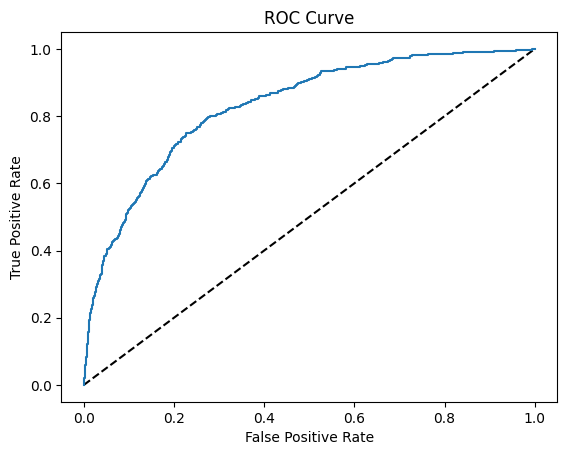

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [203]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [204]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [205]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)